In [94]:
# Import all the important stuff I might need

import scipy.stats as stats
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

from sklearn.cluster import KMeans, k_means, DBSCAN
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegressionCV
from sklearn.metrics import accuracy_score, mean_squared_error, silhouette_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
from statsmodels.tsa.arima_model import ARMA

from datetime import datetime
from datetime import timedelta

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from hdbscan import HDBSCAN

import bokeh
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

plt.style.use('seaborn')
sns.set(style="white")

%matplotlib inline

In [95]:
# load player data
# not individual stats, but personal info
players = pd.read_csv('./data/People.csv')

#load batting data
batting = pd.read_csv('./data/Batting.csv')

#load post season batting data
batting_post = pd.read_csv('./data/BattingPost.csv')

#load pitching data
pitching = pd.read_csv('./data/Pitching.csv')

#load post season pitching data
pitching_post = pd.read_csv('./data/PitchingPost.csv')

#load salary data
salaries = pd.read_csv('./data/Salaries.csv')

#load team data
teams = pd.read_csv('./data/Teams.csv')

#load fielding data
fielding = pd.read_csv('./data/Fielding.csv')

#load post season fielding data
fielding_post = pd.read_csv('./data/FieldingPost.csv')

In [96]:
#standardize column names
batting.columns = map(str.lower, batting.columns)
batting_post.columns = map(str.lower, batting_post.columns)
pitching.columns = map(str.lower, pitching.columns)
pitching_post.columns = map(str.lower, pitching_post.columns)
salaries.columns = map(str.lower, salaries.columns)
teams.columns = map(str.lower, teams.columns)
fielding.columns = map(str.lower, fielding.columns)
fielding_post.columns = map(str.lower, fielding_post.columns)
players.columns = map(str.lower, players.columns)

In [97]:
#rename 'yearid' column to year for ease
batting.rename(columns={'yearid':'year'}, inplace=True)
batting_post.rename(columns={'yearid':'year'}, inplace=True)
pitching.rename(columns={'yearid': 'year'}, inplace=True)
pitching_post.rename(columns={'yearid': 'year'}, inplace=True)
salaries.rename(columns={'yearid': 'year'}, inplace=True)
teams.rename(columns={'yearid': 'year'}, inplace=True)
fielding.rename(columns={'yearid': 'year'}, inplace=True)
fielding_post.rename(columns={'yearid':'year'}, inplace=True)

In [98]:
# concat post and regular season stats to get a true value for career stats
batting = pd.concat([batting, batting_post], join='inner')
pitching = pd.concat([pitching, pitching_post], join='inner')
fielding = pd.concat([fielding, fielding_post], join='inner')

In [99]:
#use fillna() to replace NaN for years stat wasn't recorded
#need to figure out a way to fix pitching data, since 0 will be beneficaial in a few cases
batting.fillna(value=0, inplace=True)
batting_post.fillna(value=0, inplace=True)
pitching.fillna(value=0, inplace=True)
pitching_post.fillna(value=0, inplace=True)
teams.fillna(value=0, inplace=True)
fielding.fillna(value=0, inplace=True)
fielding_post.fillna(value=0, inplace=True)

In [100]:
batting['period'] = batting['year']
batting['period'].replace(range(1871,1901), 0, inplace=True)
batting['period'].replace(range(1901,1920), 1, inplace=True)
batting['period'].replace(range(1920, 1942), 2, inplace=True)
batting['period'].replace(range(1942, 1961), 3, inplace=True)
batting['period'].replace(range(1961, 1977), 4, inplace=True)
batting['period'].replace(range(1977, 1994), 5, inplace=True)
batting['period'].replace(range(1994, 2006), 6, inplace=True)
batting['period'].replace(range(2006, 2018), 7, inplace=True)

In [101]:
pitching['period'] = pitching['year']
pitching['period'].replace(range(1871, 1901), 0, inplace=True)
pitching['period'].replace(range(1901, 1920), 1, inplace=True)
pitching['period'].replace(range(1920, 1942), 2, inplace=True)
pitching['period'].replace(range(1942, 1961), 3, inplace=True)
pitching['period'].replace(range(1961, 1977), 4, inplace=True)
pitching['period'].replace(range(1977, 1994), 5, inplace=True)
pitching['period'].replace(range(1994, 2006), 6, inplace=True)
pitching['period'].replace(range(2006, 2018), 7, inplace=True)

In [102]:
fielding['period'] = fielding['year']
fielding['period'].replace(range(1871, 1901), 0, inplace=True)
fielding['period'].replace(range(1901, 1920), 1, inplace=True)
fielding['period'].replace(range(1920, 1942), 2, inplace=True)
fielding['period'].replace(range(1942, 1961), 3, inplace=True)
fielding['period'].replace(range(1961, 1977), 4, inplace=True)
fielding['period'].replace(range(1977, 1994), 5, inplace=True)
fielding['period'].replace(range(1994, 2006), 6, inplace=True)
fielding['period'].replace(range(2006, 2018), 7, inplace=True)

In [103]:
#remove player with fewer than 100 at bats for a given year
# will need to re-evaluate number later
batting = batting[batting['ab'] >= 100]

In [104]:
# remove players with fewer than 10 game appearances for a given year
# again, will need to re-evaluate number later
pitching = pitching[pitching['g'] >= 10]

In [105]:
# remove players with fewer than 20 outfield appearances for a given year
# will need to re-evalute later for seasons with less than 162 games.
fielding = fielding[fielding['g'] >= 20]

In [106]:
# create batting average column
# I used basic batting average formula
batting['bavg'] = batting['h']/batting['ab']

In [107]:
# create on base percentage column
batting['obp'] = (batting['h']+batting['bb']+batting['hbp']) / (batting['ab']+batting['bb']+batting['hbp']+batting['sf'])

In [108]:
# create singles column
batting['1b'] = batting['h']-(batting['2b']+batting['3b']+batting['hr'])

In [109]:
# create slugging percentage column
batting['slg'] = (batting['1b']+(2*batting['2b'])+(3*batting['3b'])+(4*batting['hr'])) / batting['ab']

In [110]:
# create on base plus slugging column
batting['ops'] = batting['obp']+batting['slg']

In [111]:
# created estimated pitch count column to see trends over time
# this is an estimate used from metrics found elsewhere
# not an offical stat until 1954
pitching['est_pc'] = 3 * (pitching['h'] + (4 * pitching['bb']) + (3 * pitching['so']) + pitching['wp'])

In [112]:
# created fielding percentage column
fielding['fp%'] = ((fielding['po']+fielding['a']) / (fielding['po']+fielding['a']+fielding['e']))

In [113]:
# created range fielding per game column
fielding['rf/g'] = (fielding['po']+fielding['a']) / fielding['g']

In [114]:
# created walks plus hits per inning pitched
pitching['whip'] = (pitching['bb']+pitching['h']) / (3*pitching['ipouts'])

In [115]:
#round batting average down to 3 significant digits to better group players
batting = round(batting, 3)
pitching = round(pitching, 3)
fielding = round(fielding, 3)

In [116]:
#replace bats and throws with numbers
players['bats'].replace({'R':1, 'L':2, 'B':3,}, inplace=True)
players['throws'].replace({'R':1, 'L':2, 'S':4}, inplace=True)

In [117]:
# We only need certain data from player dataset
# Right =1
# Left =2
#Both =3
#S =4 : find what s means
players = players.groupby('playerid').sum()
players = players[['weight', 'height', 'bats', 'throws']]

## We need major league baseball data!

I realized while doing eda that there is minor league and alternative league stats for players. While this is cool to have, we don't need it for the scope of this project. So I will create new datasets with just the NL and AL league ids.

In [118]:
batting_al = batting[batting['lgid'] == 'AL']
batting_nl = batting[batting['lgid'] == 'NL']
batting = pd.concat([batting_al, batting_nl], axis=0)

In [119]:
pitching_al = pitching[pitching['lgid'] == 'AL']
pitching_nl = pitching[pitching['lgid'] == 'NL']
pitching = pd.concat([pitching_al, pitching_nl], axis=0)

In [120]:
fielding_al = fielding[fielding['lgid'] == 'AL']
fielding_nl = fielding[fielding['lgid'] == 'NL']
fielding = pd.concat([fielding_al, fielding_nl], axis=0)

In [121]:
teams_al = teams[teams['lgid'] == 'AL']
teams_nl = teams[teams['lgid'] == 'NL']
teams_mlb = pd.concat([teams_al, teams_nl], axis=0).shape

In [122]:
salaries_al = salaries[salaries['lgid'] == 'AL']
salaries_nl = salaries[salaries['lgid'] == 'NL']
salaries = pd.concat([salaries_al, salaries_nl], axis=0)

The players individual data doesn't include teams they played for, which is fine because this dataset will be used to reference player height and weight stats.

## Let's create some new datasets for career stats and stats by year and stats for player by year

### Batting

In [123]:
batters = batting.groupby('playerid').sum()
batters.drop(columns=(['year', 'bavg', 'obp', 'ops', 'slg','period']), inplace=True)
batters['years'] = batting.groupby('playerid')['year'].count()
batters['period'] = batting.groupby('playerid')['period'].mean()
batters['bavg'] = batting.groupby('playerid')['bavg'].mean()
batters['obp'] = batting.groupby('playerid')['obp'].mean()
batters['ops'] = batting.groupby('playerid')['ops'].mean()
batters['slg'] = batting.groupby('playerid')['slg'].mean()
batters = round(batters, 3)

In [124]:
batting_year = batting.groupby('year').sum()
batting_year.drop(columns=(['bavg', 'obp', 'ops', 'slg', 'period']), inplace=True)
batting_year['period'] = batting.groupby('year')['period'].mean()
# batting_year['trades'] = batting_year['stint']
# batting_year.drop(['stint'], axis=1, inplace=True)
batting_year['bavg'] = batting.groupby('year')['bavg'].mean()
batting_year['obp'] = batting.groupby('year')['obp'].mean()
batting_year['ops'] = batting.groupby('year')['ops'].mean()
batting_year['slg'] = batting.groupby('year')['slg'].mean()
batting_year = round(batting_year, 3)

In [125]:
batters_years = batting.groupby(['playerid', 'year']).sum()
batters_years.drop(columns=(['bavg', 'obp', 'ops', 'slg', 'period']), inplace=True)
batters_years['period'] = batting.groupby(['playerid', 'year'])['period'].mean()
# # # batters['years'] = batting.groupby(['playerid', 'year'])['year'].count()
batters_years['bavg'] = batting.groupby(['playerid', 'year'])['bavg'].mean()
batters_years['obp'] = batting.groupby(['playerid', 'year'])['obp'].mean()
batters_years['ops'] = batting.groupby(['playerid', 'year'])['ops'].mean()
batters_years['slg'] = batting.groupby(['playerid', 'year'])['slg'].mean()
batters_years = round(batters_years, 3)

In [126]:
batting_team = batting.groupby(['teamid']).sum()
batting_team.drop(columns=['year', 'bavg', 'obp', 'ops', 'slg', 'period'], inplace=True)
# batting_team['years'] = batting.groupby('teamid')['year'].count()
batting_team['period'] = batting.groupby('teamid')['period'].mean()
batting_team['bavg'] = batting.groupby('teamid')['bavg'].mean()
batting_team['obp'] = batting.groupby('teamid')['obp'].mean()
batting_team['ops'] = batting.groupby('teamid')['ops'].mean()
batting_team['slg'] = batting.groupby('teamid')['slg'].mean()
batting_team = round(batting_team, 3)

In [127]:
batting_team_year = batting.groupby(['teamid', 'year']).sum()
batting_team_year.drop(columns=['bavg', 'obp', 'ops', 'slg', 'period'], inplace=True)
batting_team_year['period'] = batting.groupby(['teamid', 'year'])['period'].mean()
batting_team_year['bavg'] = batting.groupby(['teamid', 'year'])['bavg'].mean()
batting_team_year['obp'] = batting.groupby(['teamid', 'year'])['obp'].mean()
batting_team_year['ops'] = batting.groupby(['teamid', 'year'])['ops'].mean()
batting_team_year['slg'] = batting.groupby(['teamid', 'year'])['slg'].mean()
batting_team_year = round(batting_team_year,3)

### Pitching

In [128]:
pitchers = pitching.groupby('playerid').sum()
pitchers.drop(columns=(['year', 'era', 'whip', 'period']), inplace=True)
pitchers['years'] = pitching.groupby('playerid')['year'].count()
pitchers['period'] = pitching.groupby('playerid')['period'].mean()
pitchers['era'] = pitching.groupby('playerid')['era'].mean()
pitchers['whip'] = pitching.groupby('playerid')['whip'].mean()
pitchers = round(pitchers, 3)

In [129]:
pitching_year = pitching.groupby('year').sum()
pitching_year.drop(columns=(['era','whip', 'period']), inplace=True)
# pitching_year['trades'] = pitching_year['stint']
# pitching_year.drop(['stint'], axis=1, inplace=True)
pitching_year['period'] = pitching.groupby('year')['period'].mean()
pitching_year['era'] = pitching.groupby('year')['era'].mean()
pitching_year['whip'] = pitching.groupby('year')['whip'].mean()
pitching_year = round(pitching_year, 3)

In [130]:
pitchers_years = pitching.groupby(['playerid', 'year']).sum()
pitchers_years.drop(columns=(['era','whip', 'period']), inplace=True)
# batters['years'] = batting.groupby(['playerid', 'year'])['year'].count()
pitchers_years['era'] = pitching.groupby(['playerid', 'year'])['era'].mean()
pitchers_years['period'] = pitching.groupby(['playerid', 'year'])['period'].mean()
pitchers_years['era'] = pitching.groupby(['playerid', 'year'])['whip'].mean()
pitchers_years = round(pitchers_years, 3)

In [131]:
pitching_team = pitching.groupby(['teamid']).sum()
pitching_team.drop(columns=['year', 'era', 'whip', 'period'], inplace=True)
pitching_team['era'] = pitching.groupby('teamid')['era'].mean()
pitching_team['period'] = pitching.groupby('teamid')['period'].mean()
pitching_team['whip'] = pitching.groupby('teamid')['whip'].mean()
pitching_team = round(pitching_team, 3)

In [132]:
pitching_team_year = pitching.groupby(['teamid', 'year']).sum()
pitching_team_year.drop(columns=['era', 'whip', 'period'], inplace=True)
pitching_team_year['era'] = pitching.groupby(['teamid', 'year'])['era'].mean()
pitching_team_year['period'] = pitching.groupby(['teamid', 'year'])['period'].mean()
pitching_team_year['whip'] = pitching.groupby(['teamid', 'year'])['whip'].mean()
pitching_team_year = round(pitching_team_year,3)

### Fielding

In [133]:
fielders = fielding.groupby('playerid').sum()
fielders.drop(columns=(['year', 'fp%', 'rf/g','period']), inplace=True)
fielders['years'] = fielding.groupby('playerid')['year'].count()
fielders['period'] = fielding.groupby('playerid')['period'].mean()
fielders['fp%'] = fielding.groupby('playerid')['fp%'].mean()
fielders['rf/g'] = fielding.groupby('playerid')['rf/g'].mean()
fielders.fillna(value=0, inplace=True)

In [134]:
fielding_year = fielding.groupby(['year']).sum()
# fielding_year['trades'] = fielding_year['stint']
fielding_year.drop(['fp%', 'rf/g', 'period'], axis=1, inplace=True)
fielding_year['fp%'] = fielding.groupby('year')['fp%'].mean()
fielding_year['period'] = fielding.groupby('year')['period'].mean()
fielding_year['rf/g'] = fielding.groupby('year')['rf/g'].mean()
fielding_year.fillna(value=0, inplace=True)

In [135]:
fielders_years = fielding.groupby(['playerid', 'year']).sum()
fielders_years.drop(['fp%', 'rf/g','period'], axis=1, inplace=True)
fielders_years['fp%'] = fielding.groupby(['playerid','year'])['fp%'].mean()
fielders_years['period'] = fielding.groupby(['playerid', 'year'])['period'].mean()
fielders_years['rf/g'] = fielding.groupby(['playerid','year'])['rf/g'].mean()
fielders_years.fillna(value=0, inplace=True)

In [136]:
fielding_team = fielding.groupby(['teamid']).sum()
fielding_team.drop(columns=['year', 'fp%', 'rf/g','period'], inplace=True)
# batting_team['years'] = batting.groupby('teamid')['year'].count()
fielding_team['fp%'] = fielding.groupby('teamid')['fp%'].mean()
fielding_team['period'] = fielding.groupby('teamid')['period'].mean()
fielding_team['rf/g'] = fielding.groupby('teamid')['rf/g'].mean()
fielding_team = round(fielding_team, 3)

In [137]:
fielding_team_year = fielding.groupby(['teamid', 'year', 'period']).sum()
fielding_team_year.drop(columns=['fp%', 'rf/g'], inplace=True)
fielding_team_year['fp%'] = fielding.groupby(['teamid', 'year'])['fp%'].mean()
fielding_team_year['period'] = fielding.groupby(['teamid', 'year'])['period'].mean()
fielding_team_year['rf/g'] = fielding.groupby(['teamid', 'year'])['rf/g'].mean()
fielding_team_year = round(fielding_team_year,3)

In [138]:
import datetime

now = str(datetime.datetime.now())[:10]
# batting.to_csv(f'./data/batting_{now}', index=False)

In [139]:
batting.to_csv('./data/data/batting', index=True)
batters.to_csv('./data/data/batters', index=True)
batting_year.to_csv('./data/data/batting_year', index=True)
batters_years.to_csv('./data/data/batters_years', index=True)
batting_team.to_csv('./data/data/batting_team', index=True)
batting_team_year.to_csv('./data/data/batting_team_year', index=True)

pitching.to_csv('./data/data/pitching', index=True)
pitchers.to_csv('./data/data/pitchers', index=True)
pitching_year.to_csv('./data/data/pitching_year', index=True)
pitchers_years.to_csv('./data/data/pitchers_years', index=True)
pitching_team.to_csv('./data/data/pitching_team', index=True)
pitching_team_year.to_csv('./data/data/pitching_team_year', index=True)

fielding.to_csv('./data/data/fielding', index=True)
fielders.to_csv('./data/data/fielders', index=True)
fielding_year.to_csv('./data/data/fielding_year', index=True)
fielders_years.to_csv('./data/data/fielders_years', index=True)
fielding_team.to_csv('./data/data/fielding_team', index=True)
fielding_team_year.to_csv('./data/data/fielding_team_year', index=True)

## Let's scale some data for later use

In [140]:
# batting
ss = StandardScaler()
batters_ss = ss.fit_transform(batters)
batters_ss = pd.DataFrame(data=batters_ss, columns=batters.columns)
ss = StandardScaler()
batting_year_ss = ss.fit_transform(batting_year)
batting_year_ss = pd.DataFrame(data=batting_year_ss, columns=batting_year.columns)
ss = StandardScaler()
batters_years_ss = ss.fit_transform(batters_years)
batters_years_ss = pd.DataFrame(data=batters_years_ss, columns=batters_years.columns)
ss = StandardScaler()
batting_team_ss = ss.fit_transform(batting_team)
batting_team_ss = pd.DataFrame(data=batting_team_ss, columns=batting_team.columns)
ss = StandardScaler()
batting_team_year_ss = ss.fit_transform(batting_team_year)
batting_team_year_ss = pd.DataFrame(data=batting_team_year_ss, columns=batting_team_year.columns)

In [141]:
# pitching
ss = StandardScaler()
pitchers_ss = ss.fit_transform(pitchers)
pitchers_ss = pd.DataFrame(data=pitchers_ss, columns=pitchers.columns)
ss = StandardScaler()
pitching_year_ss = ss.fit_transform(pitching_year)
pitching_year_ss = pd.DataFrame(data=pitching_year_ss, columns=pitching_year.columns)
ss = StandardScaler()
pitchers_years_ss = ss.fit_transform(pitchers_years)
pitchers_years_ss = pd.DataFrame(data=pitchers_years_ss, columns=pitchers_years.columns)
ss = StandardScaler()
pitching_team_ss = ss.fit_transform(pitching_team)
pitching_team_ss = pd.DataFrame(data=pitching_team_ss, columns=pitching_team.columns)
ss = StandardScaler()
pitching_team_year_ss = ss.fit_transform(pitching_team_year)
pitching_team_year_ss = pd.DataFrame(data=pitching_team_year_ss, columns=pitching_team_year.columns)

In [142]:
# fieldings
ss = StandardScaler()
fielders_ss = ss.fit_transform(fielders)
fielders_ss = pd.DataFrame(data=fielders_ss, columns=fielders.columns)
ss = StandardScaler()
fielding_year_ss = ss.fit_transform(fielding_year)
fielding_year_ss = pd.DataFrame(data=fielding_year_ss, columns=fielding_year.columns)
ss = StandardScaler()
fielders_years_ss = ss.fit_transform(fielders_years)
fielders_years_ss = pd.DataFrame(data=fielders_years_ss, columns=fielders_years.columns)
ss = StandardScaler()
fielding_team_ss = ss.fit_transform(fielding_team)
fielding_team_ss = pd.DataFrame(data=fielding_team_ss, columns=fielding_team.columns)
ss = StandardScaler()
fielding_team_year_ss = ss.fit_transform(fielding_team_year)
fielding_team_year_ss = pd.DataFrame(data=fielding_team_year_ss, columns=fielding_team_year.columns)

## Time Series

### Batting

In [143]:
batting_test = batting_year

In [144]:
batting_test.head()

,g,ab,r,h,2b,3b,hr,rbi,sb,cs,...,hbp,sh,sf,gidp,1b,period,bavg,obp,ops,slg
year,,,,,,,,,,,,,,,,,,,,,
1876,4450,19157,2959,5145,614,176,40,1916.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4315,0,0.261,0.273,0.586,0.313
1877,2913,12346,1885,3417,402,192,23,1314.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2800,0,0.272,0.289,0.630,0.341
1878,3144,12953,1829,3403,466,130,23,1283.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2784,0,0.259,0.278,0.598,0.319
1879,5567,23259,3311,5997,938,314,58,2297.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4687,0,0.252,0.267,0.590,0.323
1880,5764,22915,3089,5720,953,319,61,2145.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4387,0,0.244,0.266,0.583,0.317


In [145]:
batting_test.index

Int64Index([1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885,
            ...
            2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
           dtype='int64', name='year', length=142)

In [146]:
batting_test.index = pd.date_range('1876', #start date
                         periods = len(batting_test.index), #we want the number 
                         freq = 'Y') # each period should last one month

In [147]:
batting_test.index

DatetimeIndex(['1876-12-31', '1877-12-31', '1878-12-31', '1879-12-31',
               '1880-12-31', '1881-12-31', '1882-12-31', '1883-12-31',
               '1884-12-31', '1885-12-31',
               ...
               '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31'],
              dtype='datetime64[ns]', length=142, freq='A-DEC')

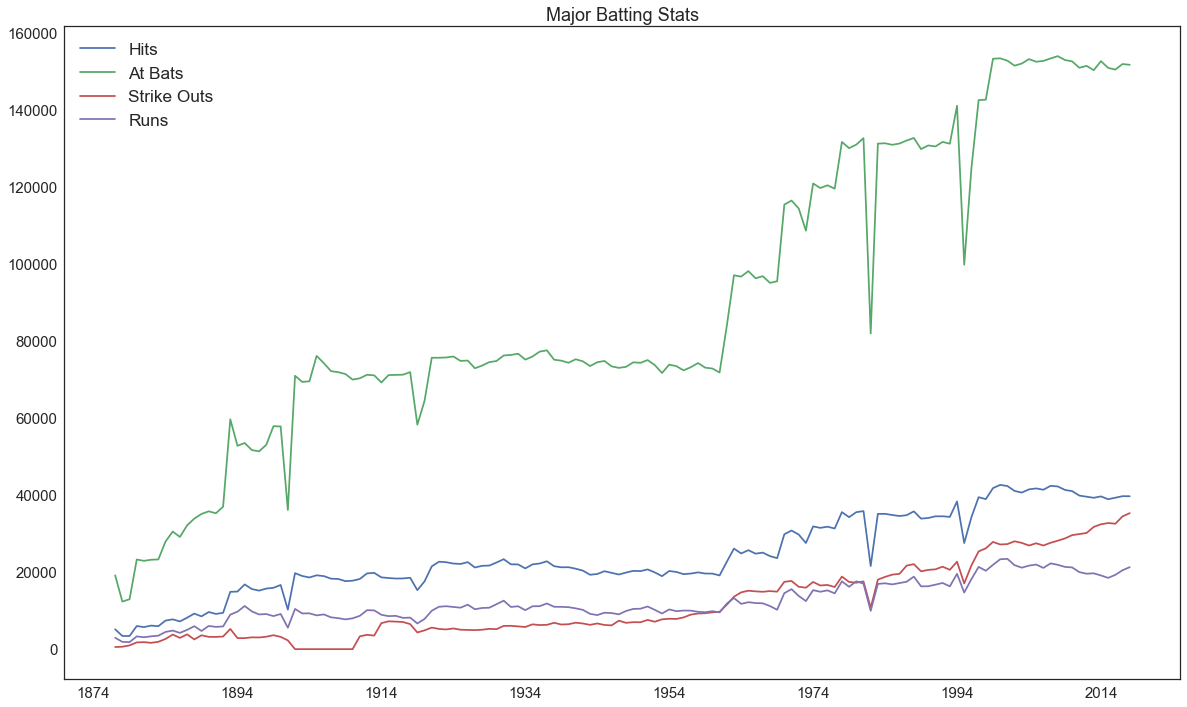

In [148]:
plt.figure(figsize = (20, 12))
plt.plot(batting_test['h'], label='Hits')
plt.plot(batting_test['ab'], label='At Bats')
plt.plot(batting_test['so'], label='Strike Outs')
plt.plot(batting_test['r'], label='Runs')
plt.title(s = "Major Batting Stats", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(axis='both', which='both', direction='inout')
plt.legend(fontsize='xx-large')
plt.show();

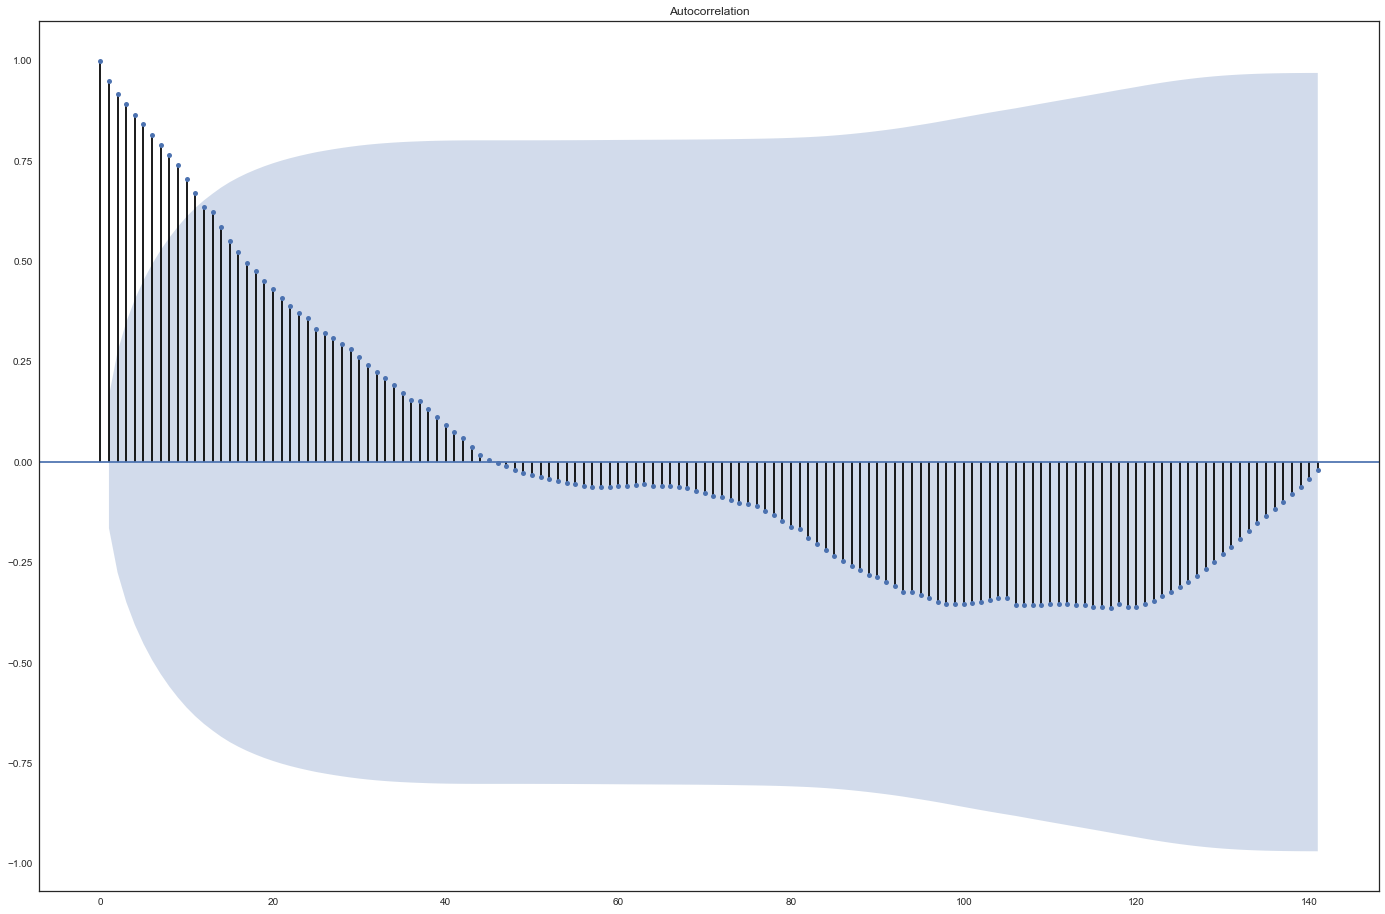

In [149]:
fig, ax = plt.subplots(figsize = (24, 16))
plot_acf(batting_test['h'], lags = 141, ax = ax)

plt.show();

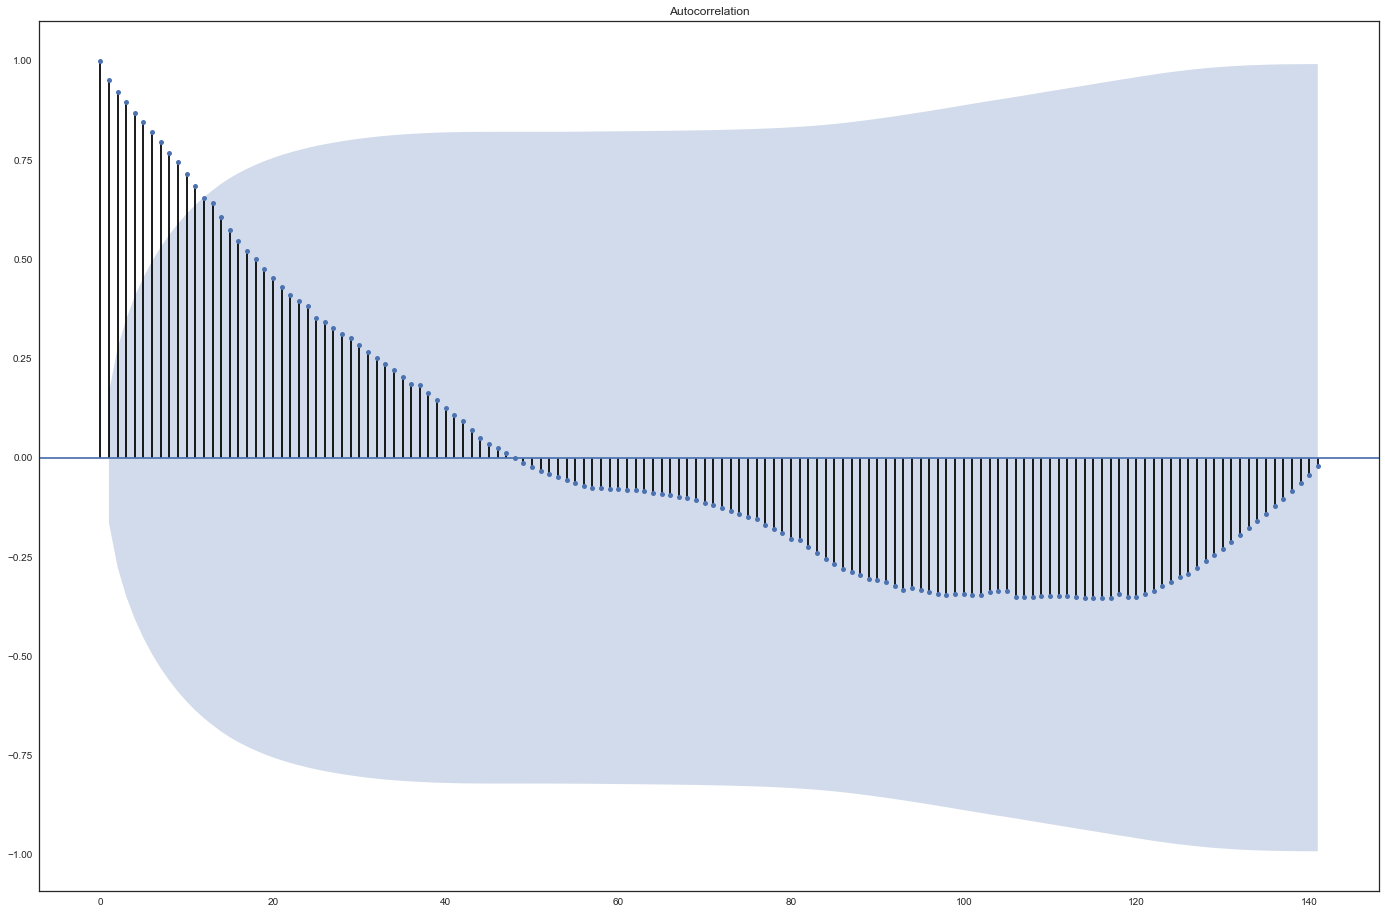

In [150]:
fig, ax = plt.subplots(figsize=(24,16))
plot_acf(batting_test['ab'], lags=141, ax=ax)
plt.show();

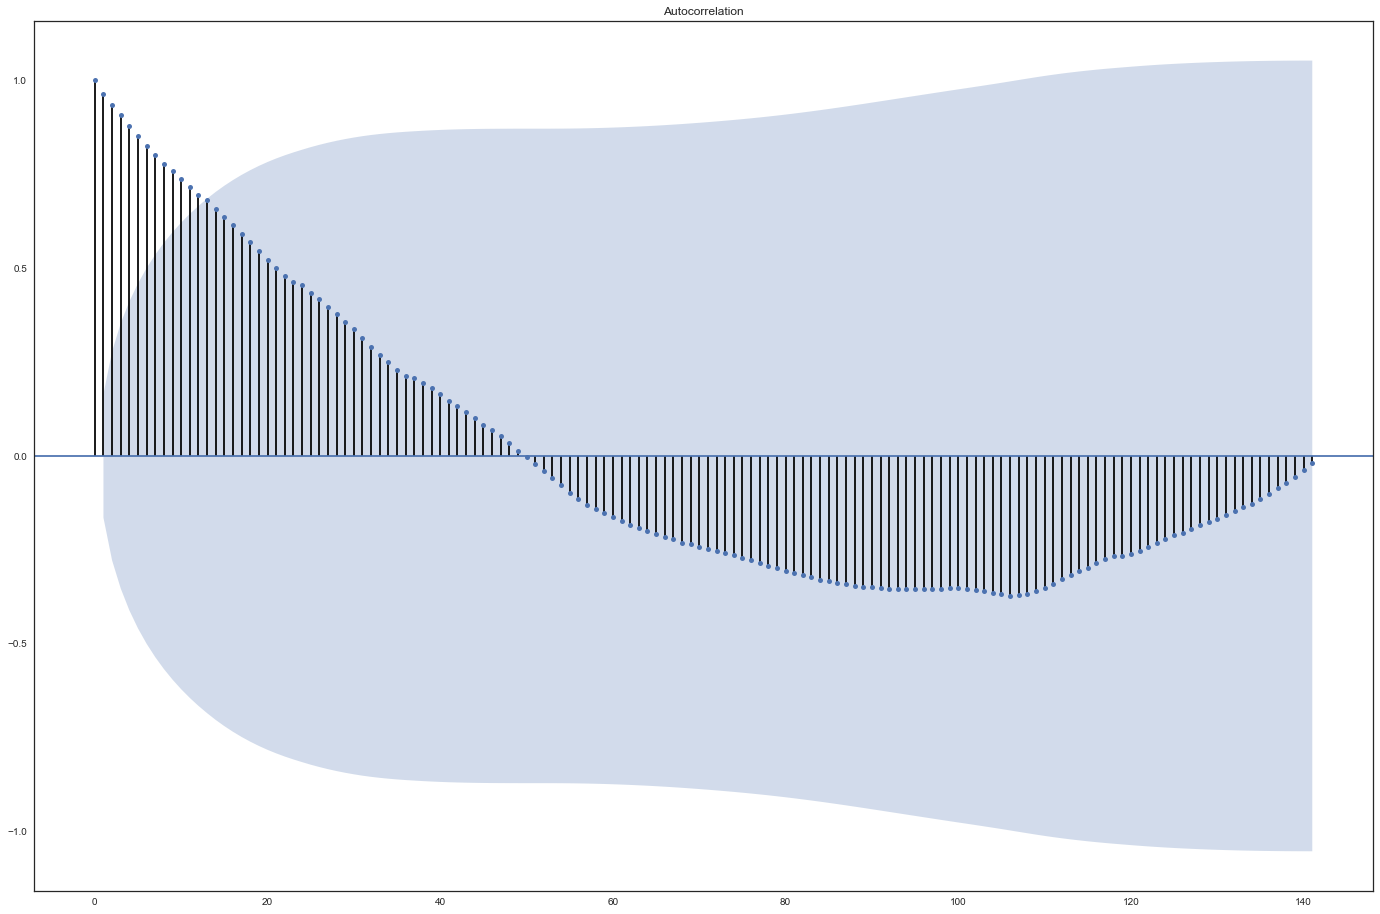

In [151]:
fig, ax =plt.subplots(figsize=(24,16))
plot_acf(batting_test['so'],lags=141, ax=ax)
plt.show();

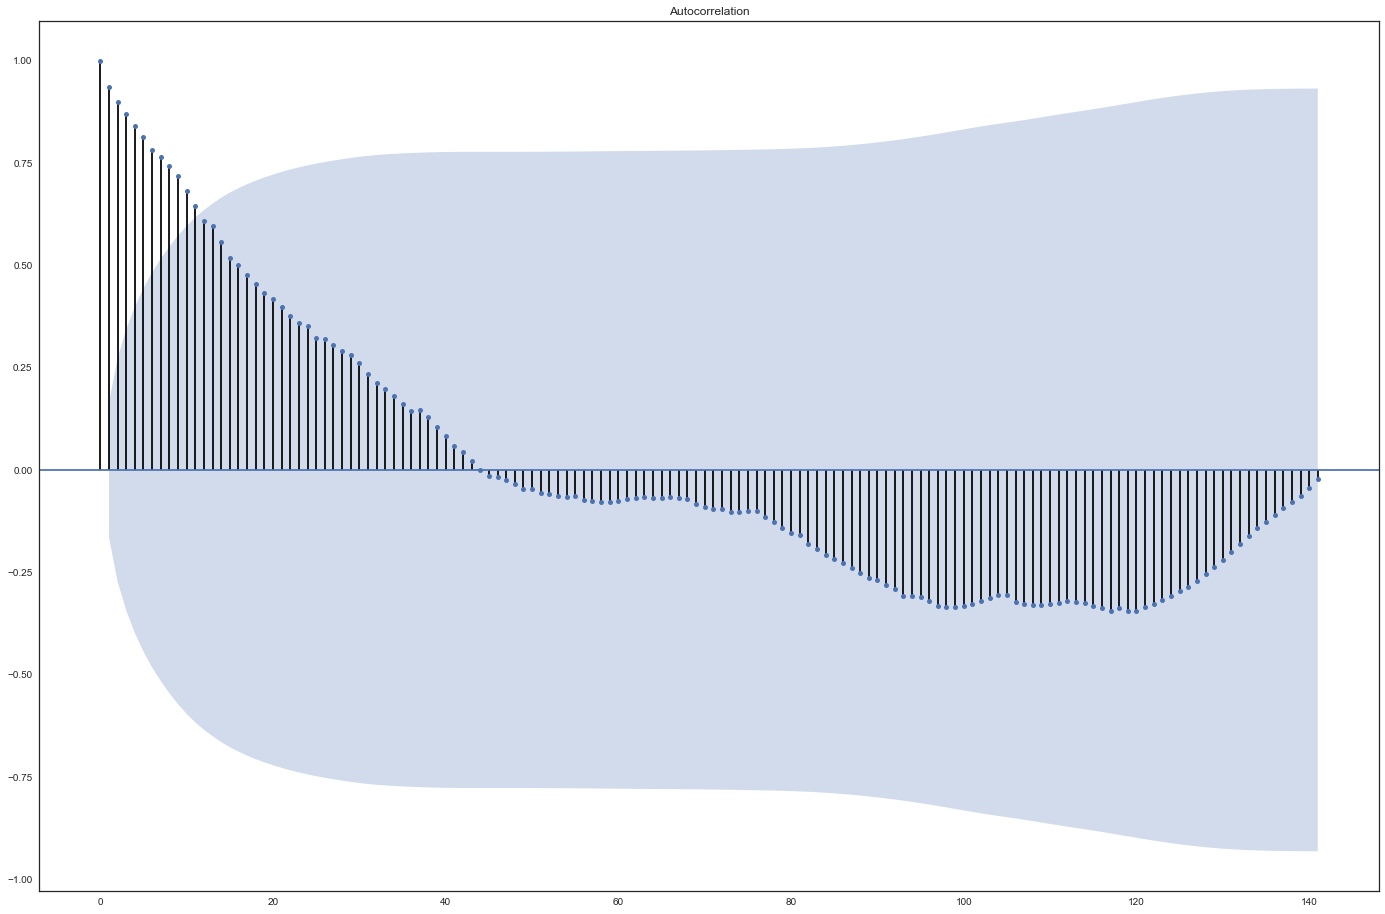

In [152]:
fig,ax=plt.subplots(figsize=(24,16))
plot_acf(batting_test['r'], lags=141, ax=ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


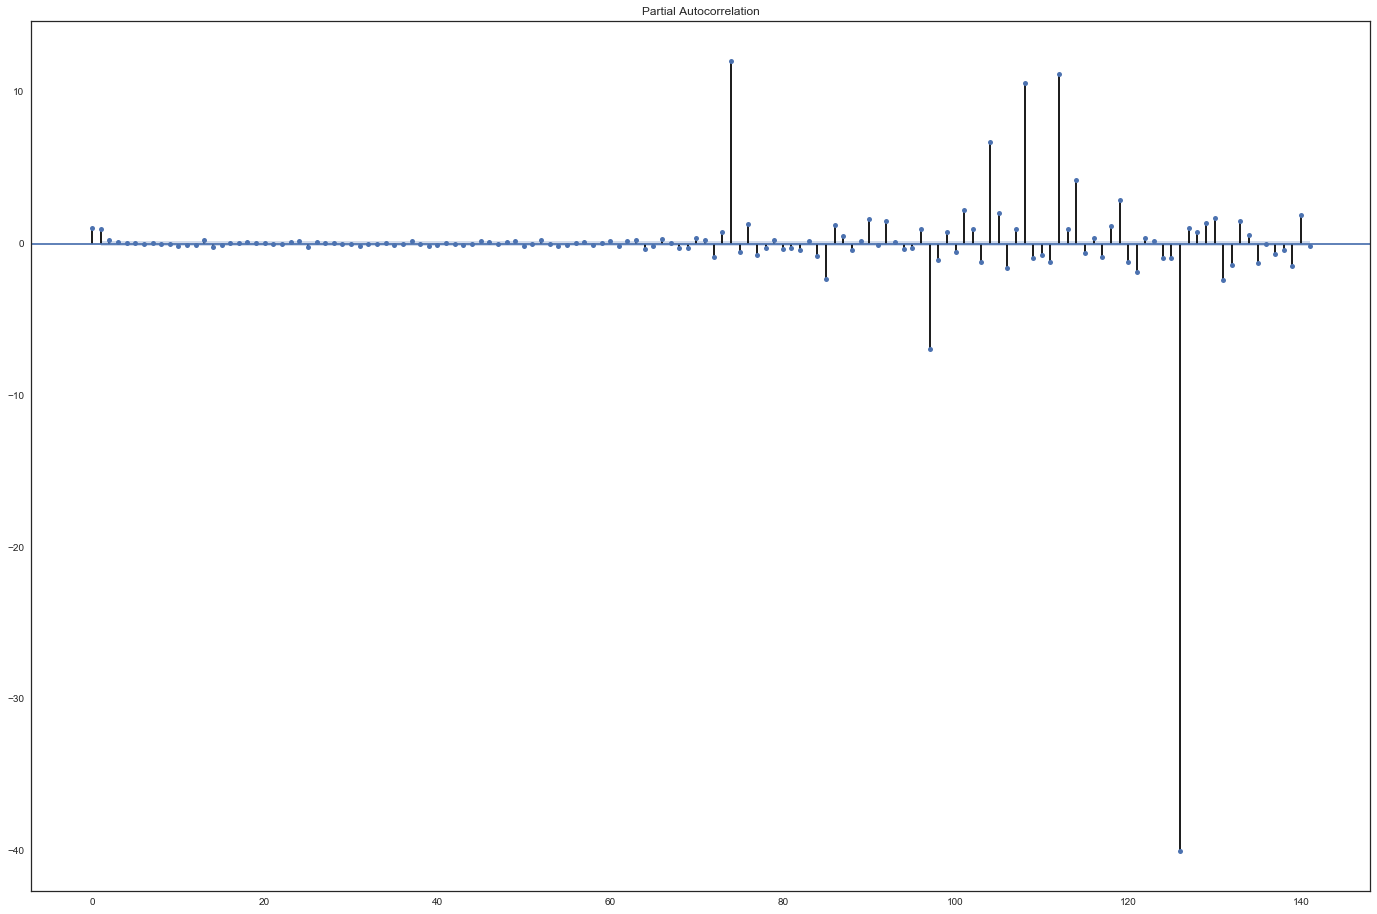

In [153]:
fig, ax = plt.subplots(figsize = (24, 16))
plot_pacf(batting_test['h'], lags = 141, ax = ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


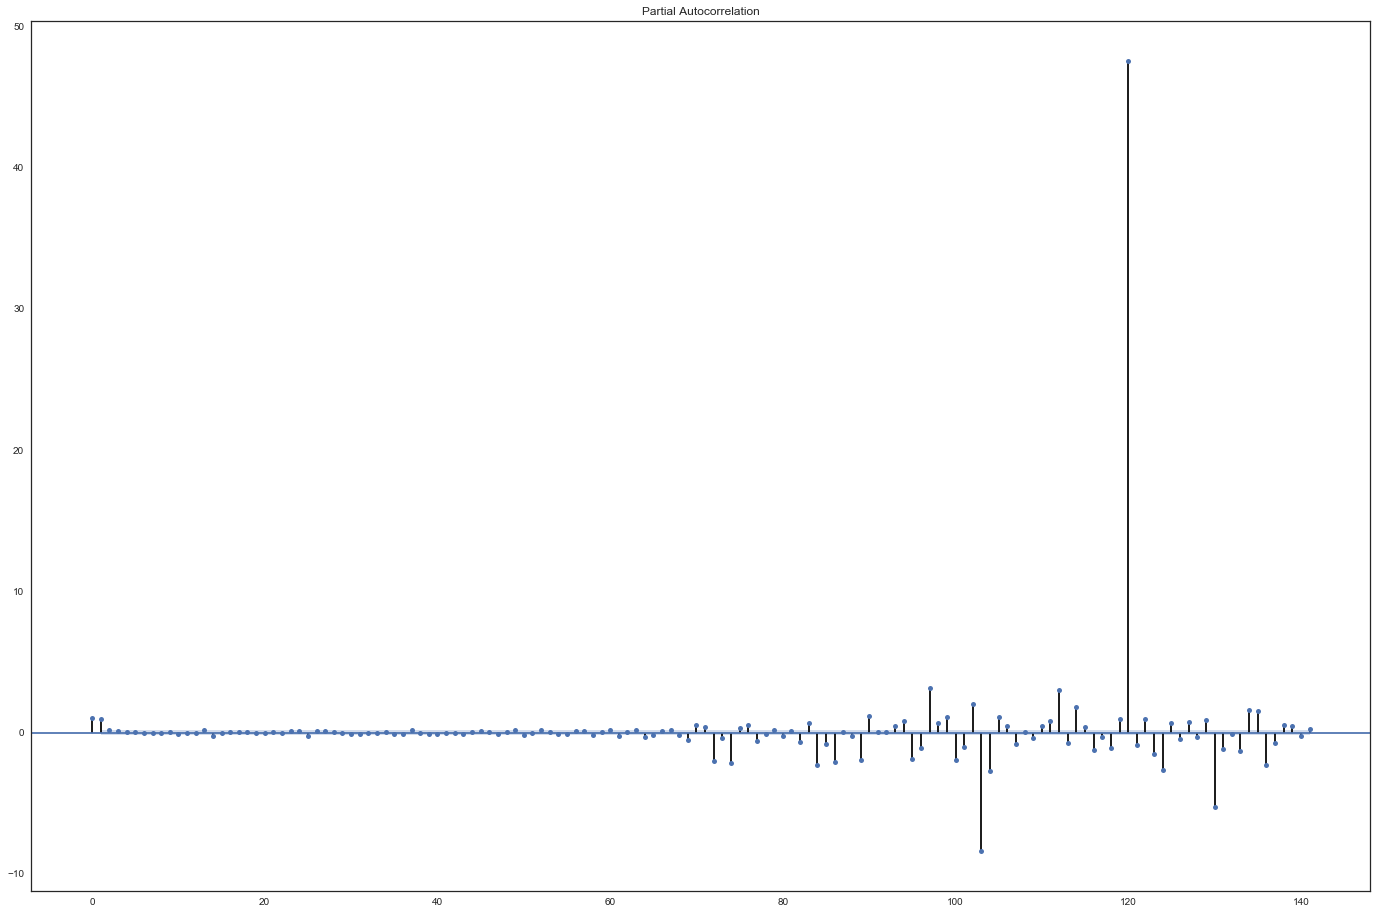

In [154]:
fig, ax = plt.subplots(figsize=(24,16))
plot_pacf(batting_test['ab'], lags=141, ax=ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


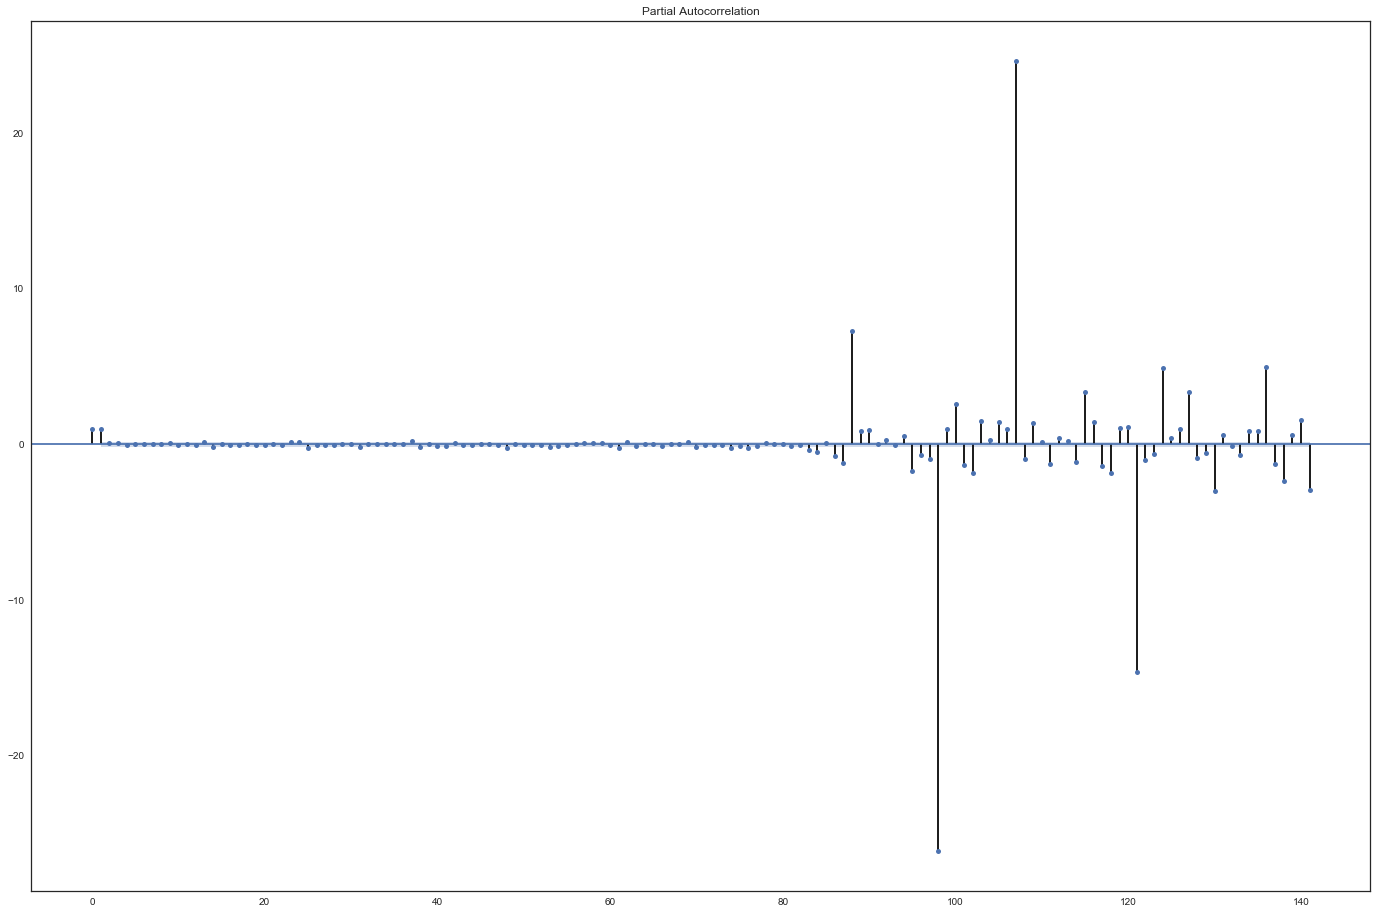

In [155]:
fig,ax = plt.subplots(figsize=(24,16))
plot_pacf(batting_test['so'], lags=141, ax=ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


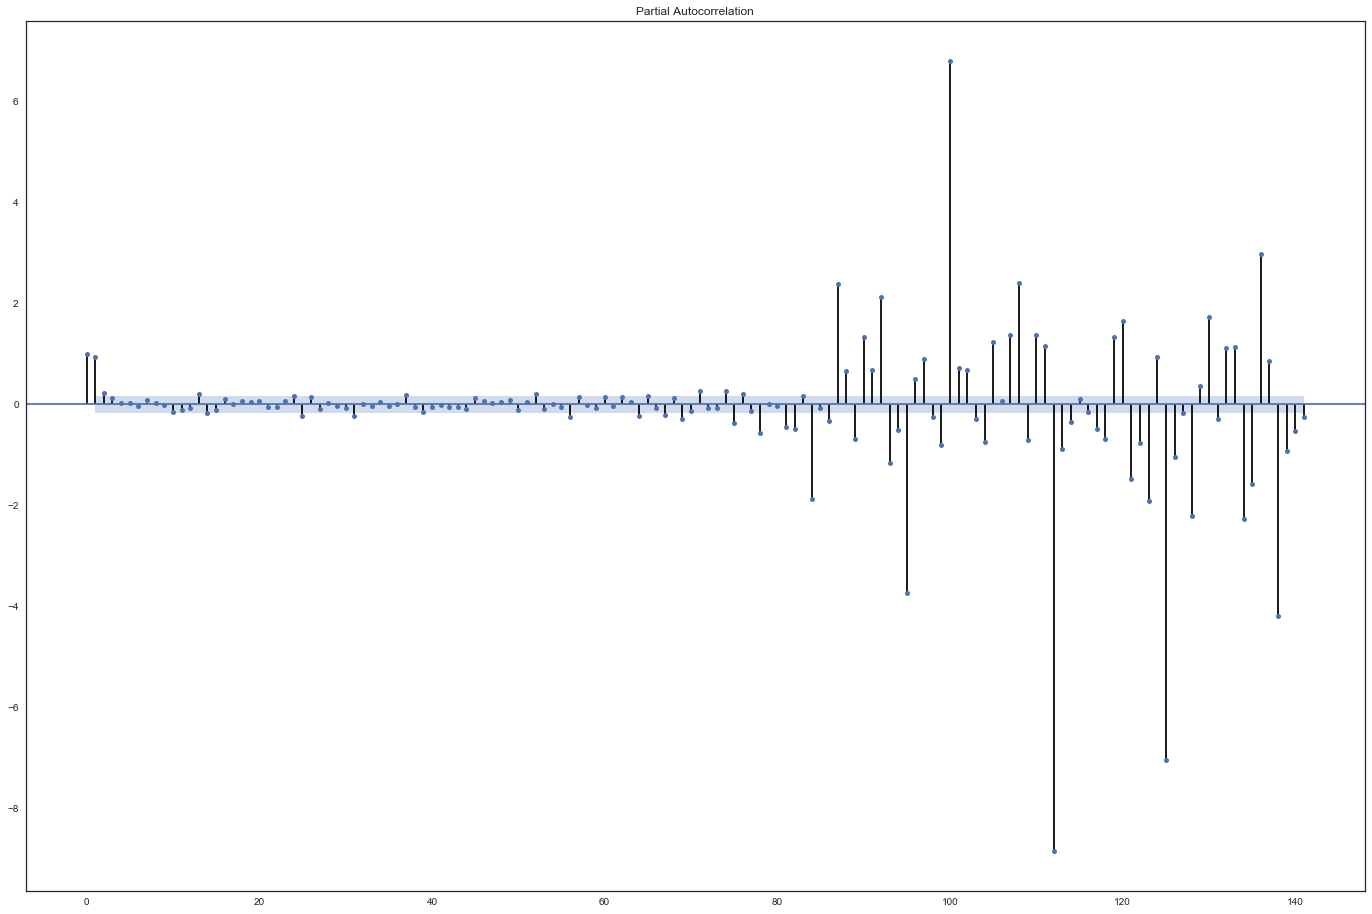

In [156]:
fig,ax=plt.subplots(figsize=(24,16))
plot_pacf(batting_test['r'], lags=141, ax=ax)
plt.show();

### in a loop

In [157]:
for i in range(1,5):
    ar = ARMA(endog = batting_test['h'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds, batting_test['h'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.909178693524152
AR(2) returns an R-squared value of: 0.9204932877637353


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AR(3) returns an R-squared value of: 0.8653997869870709
AR(4) returns an R-squared value of: 0.8460048120722204


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [158]:
r2_score(preds[4:], batting_test['h'][4:]) # skips first 4 lines that are always off because no correlated value

0.9426153184566197

In [159]:
for i in range(1,5):
    ar = ARMA(endog = batting_test['ab'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds, batting_test['ab'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.893222129338825


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AR(2) returns an R-squared value of: 0.8750774764006335


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AR(3) returns an R-squared value of: 0.8653663742217346
AR(4) returns an R-squared value of: 0.8456914731528021


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [160]:
r2_score(preds[4:], batting_test['ab'][4:]) # skips first 4 lines that are always off because no correlated value

0.9502220879558891

In [161]:
for i in range(1,5):
    ar = ARMA(endog = batting_test['so'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds, batting_test['so'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.9674675286376769


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AR(2) returns an R-squared value of: 0.9687277590166656
AR(3) returns an R-squared value of: 0.9684430734954343
AR(4) returns an R-squared value of: 0.9687034937401797


In [162]:
r2_score(preds[4:], batting_test['so'][4:]) # skips first 4 lines that are always off because no correlated value

0.9780168683065579

In [163]:
for i in range(1,5):
    ar = ARMA(endog = batting_test['r'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds, batting_test['r'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.8832411524485572
AR(2) returns an R-squared value of: 0.8942314399859088
AR(3) returns an R-squared value of: 0.8985437198712377
AR(4) returns an R-squared value of: 0.9001757730782911


In [164]:
r2_score(preds[4:], batting_test['r'][4:]) # skips first 4 lines that are always off because no correlated value

0.9155896892099938

In [165]:
ar_h = ARMA(endog = batting_test['h'], # y variable
          order= (2,0))  # (p,q) <--- talk about q later

In [166]:
model = ar_h.fit()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

In [167]:
preds = model.predict() #generated prediction values. Since autoregression, don't have to pass anything into model

In [168]:
r2_score(preds, batting_test['h'])

0.9204932877637353

In [169]:
batting_test['predicted'] = preds
batting_test[['h', 'predicted']].head(10)

,h,predicted
1876-12-31,5145,22932.189050
1877-12-31,3417,5445.380329
1878-12-31,3403,4263.294747
1879-12-31,5997,3616.108552
1880-12-31,5720,5218.814495
1881-12-31,6114,6005.618864
1882-12-31,5956,6147.484482
1883-12-31,7413,6195.134722
1884-12-31,7734,7039.867383
1885-12-31,7194,7777.209686


In [170]:
batting_test[['h', 'predicted']].tail(10)

,h,predicted
2008-12-31,41315,42073.398239
2009-12-31,41004,41454.783010
2010-12-31,39847,40926.498587
2011-12-31,39567,40094.420701
2012-12-31,39277,39493.344206
2013-12-31,39640,39210.127029
2014-12-31,38901,39327.973845
2015-12-31,39298,39004.039170
2016-12-31,39696,38977.052019
2017-12-31,39684,39370.444840


In [171]:
np.mean(batting_test['predicted'])

23968.87234724029

In [172]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      h   No. Observations:                  142
Model:                     ARMA(2, 0)   Log Likelihood               -1309.676
Method:                       css-mle   S.D. of innovations           2419.077
Date:                Wed, 17 Oct 2018   AIC                           2627.353
Time:                        21:28:14   BIC                           2639.176
Sample:                    12-31-1876   HQIC                          2632.157
                         - 12-31-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.293e+04   1.14e+04      2.010      0.046     569.755    4.53e+04
ar.L1.h        0.6198      0.078      7.988      0.000       0.468       0.772
ar.L2.h        0.3695      0.078      4.723      0.0

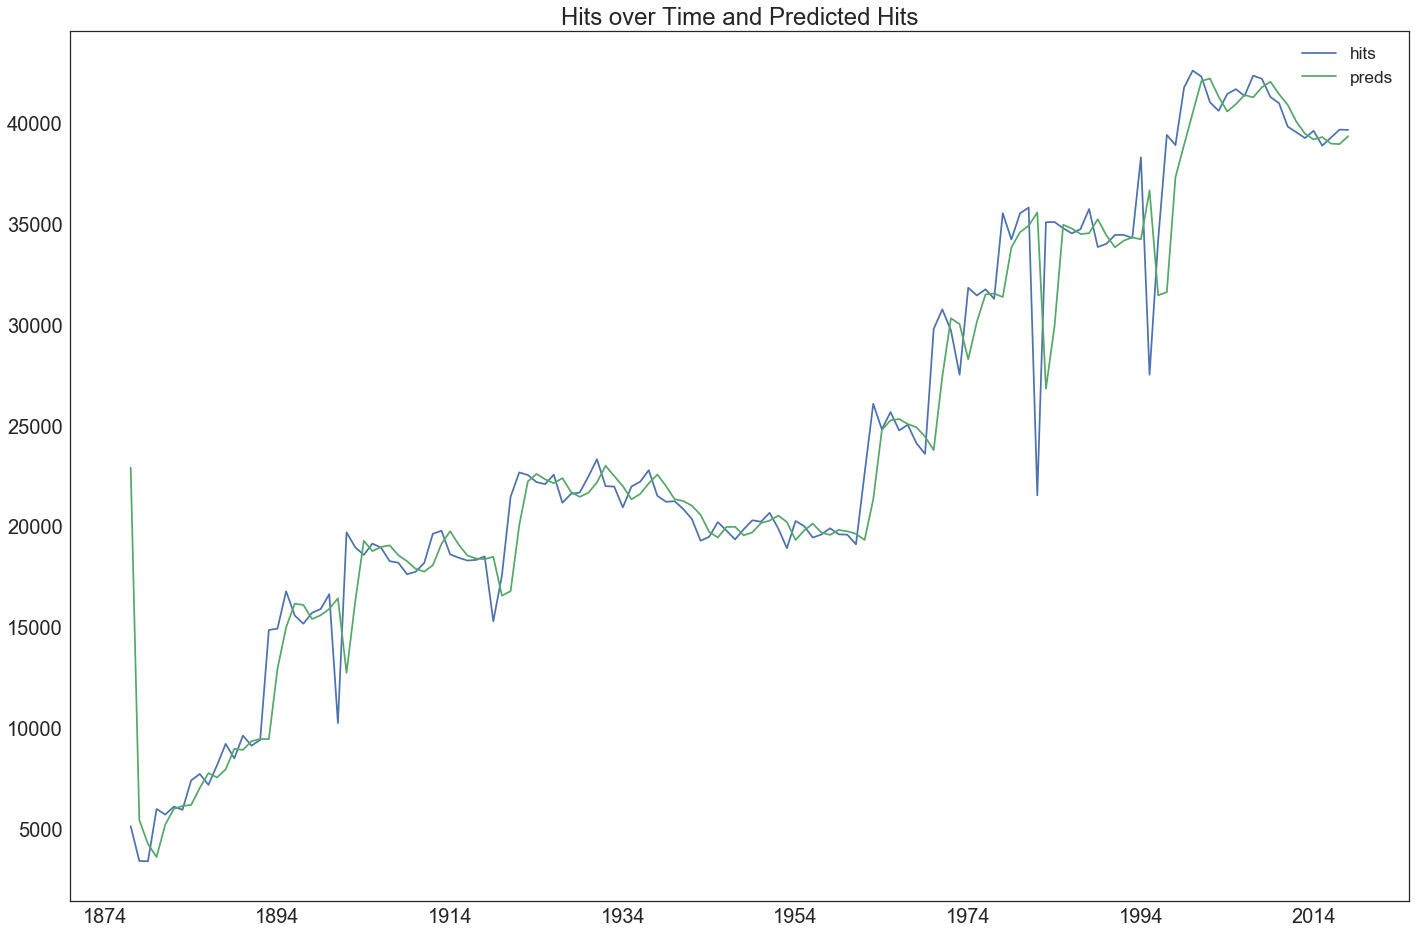

In [173]:
plt.figure(figsize=(24,16))
plt.plot(batting_test['h'], label='hits')
plt.plot(preds, label='preds')
plt.title('Hits over Time and Predicted Hits', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize='xx-large');

## forecasting

In [174]:
forecast_test = model.forecast(steps=1, # number of out of sample forecast
               exog=None, # only applies if armax
               alpha=0.05 # confidence intervals of the forecast
              )

# returns forecast, std err, and confidence interval range

In [175]:
forecast_test

(array([39510.07054109]),
 array([2419.07692487]),
 array([[34768.76689252, 44251.37418966]]))

In [176]:
forecast_test[0]

array([39510.07054109])

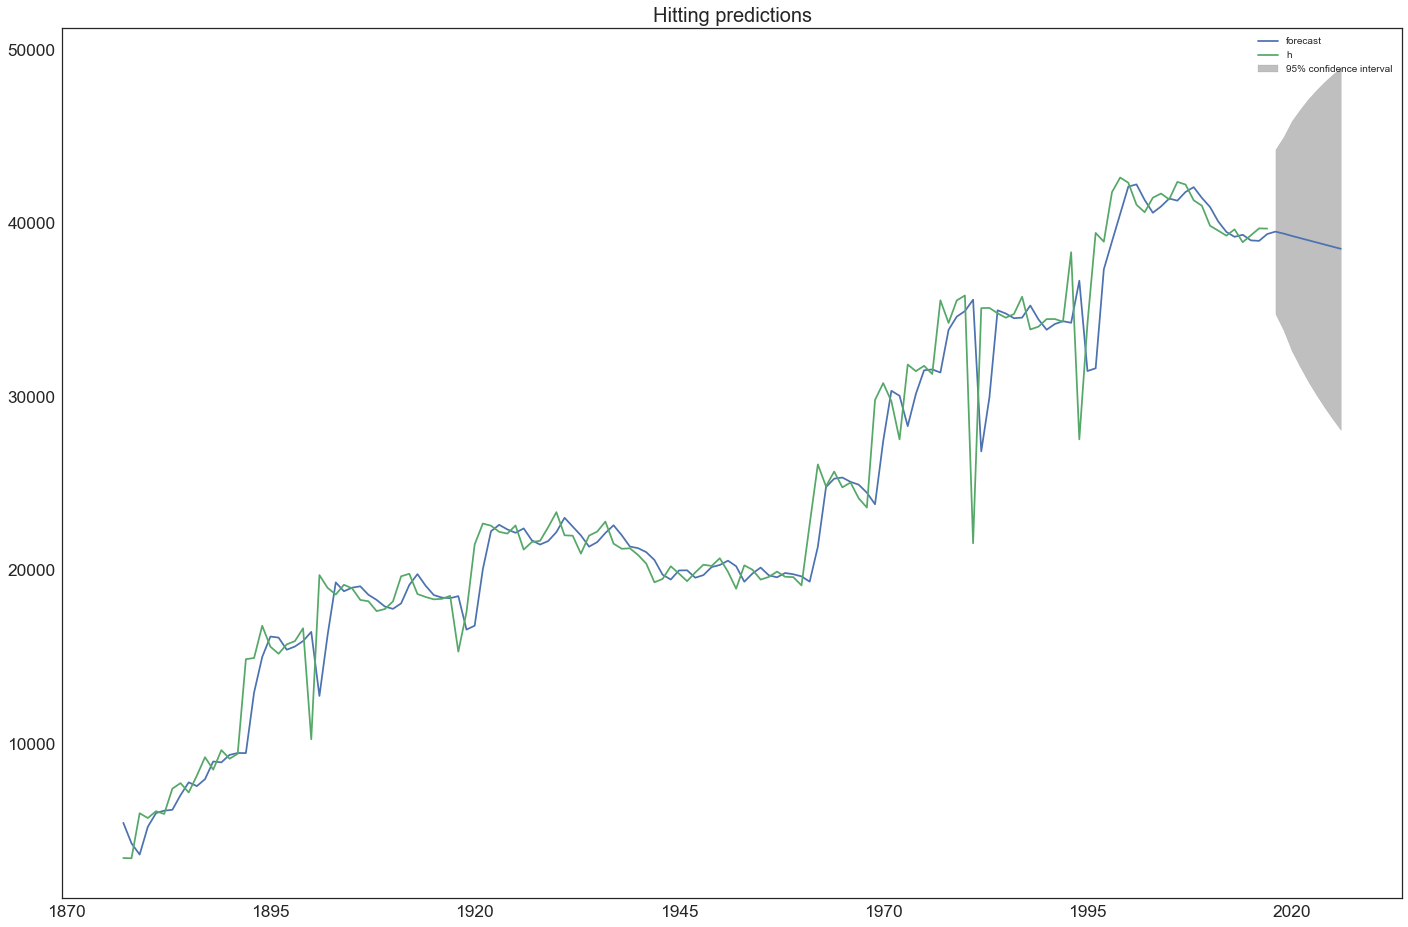

In [177]:
fig, ax = plt.subplots(figsize = (24, 16))
ax.set_title('Hitting predictions', fontsize=20)
ax.tick_params(labelsize='xx-large')
model.plot_predict(start=1, end=150, alpha=0.05, ax = ax)

plt.show();

### Pitching

In [178]:
pitching_year.index

Int64Index([1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885,
            ...
            2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
           dtype='int64', name='year', length=142)

In [179]:
pitching_year['year'] = pitching_year.index

In [180]:
pitching_year.index = pd.date_range('1876', #start date
                         periods = len(batting_test.index), #we want the number 
                         freq = 'Y') # each period should last one month

In [186]:
pitching_year.columns

Index(['w', 'l', 'g', 'gs', 'cg', 'sho', 'sv', 'ipouts', 'h', 'er', 'hr', 'bb',
       'so', 'baopp', 'ibb', 'wp', 'hbp', 'bk', 'bfp', 'gf', 'r', 'sh', 'sf',
       'gidp', 'est_pc', 'period', 'era', 'whip', 'year'],
      dtype='object')

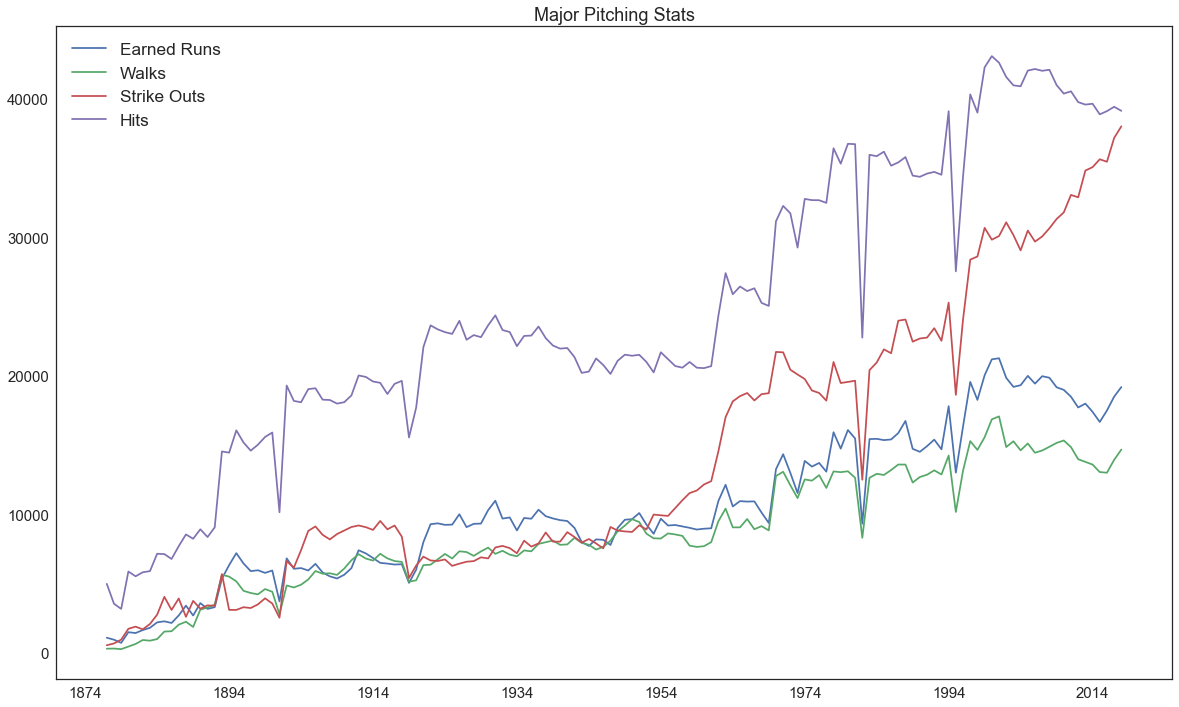

In [192]:
plt.figure(figsize = (20, 12))
plt.plot(pitching_year['er'], label='Earned Runs')
# sns.regplot(x=pitching_year['year'], y=pitching_year['er'],
#              scatter=False, logistic=False, order=1)
plt.plot(pitching_year['bb'], label='Walks')
# sns.regplot(x=pitching_year['year'], y=pitching_year['bb'],
#             scatter=False, logistic=False, order=1)
plt.plot(pitching_year['so'], label='Strike Outs')
plt.plot(pitching_year['h'], label='Hits')
plt.title(s = "Major Pitching Stats", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(axis='both', which='both', direction='inout')
plt.legend(fontsize='xx-large')
plt.show();

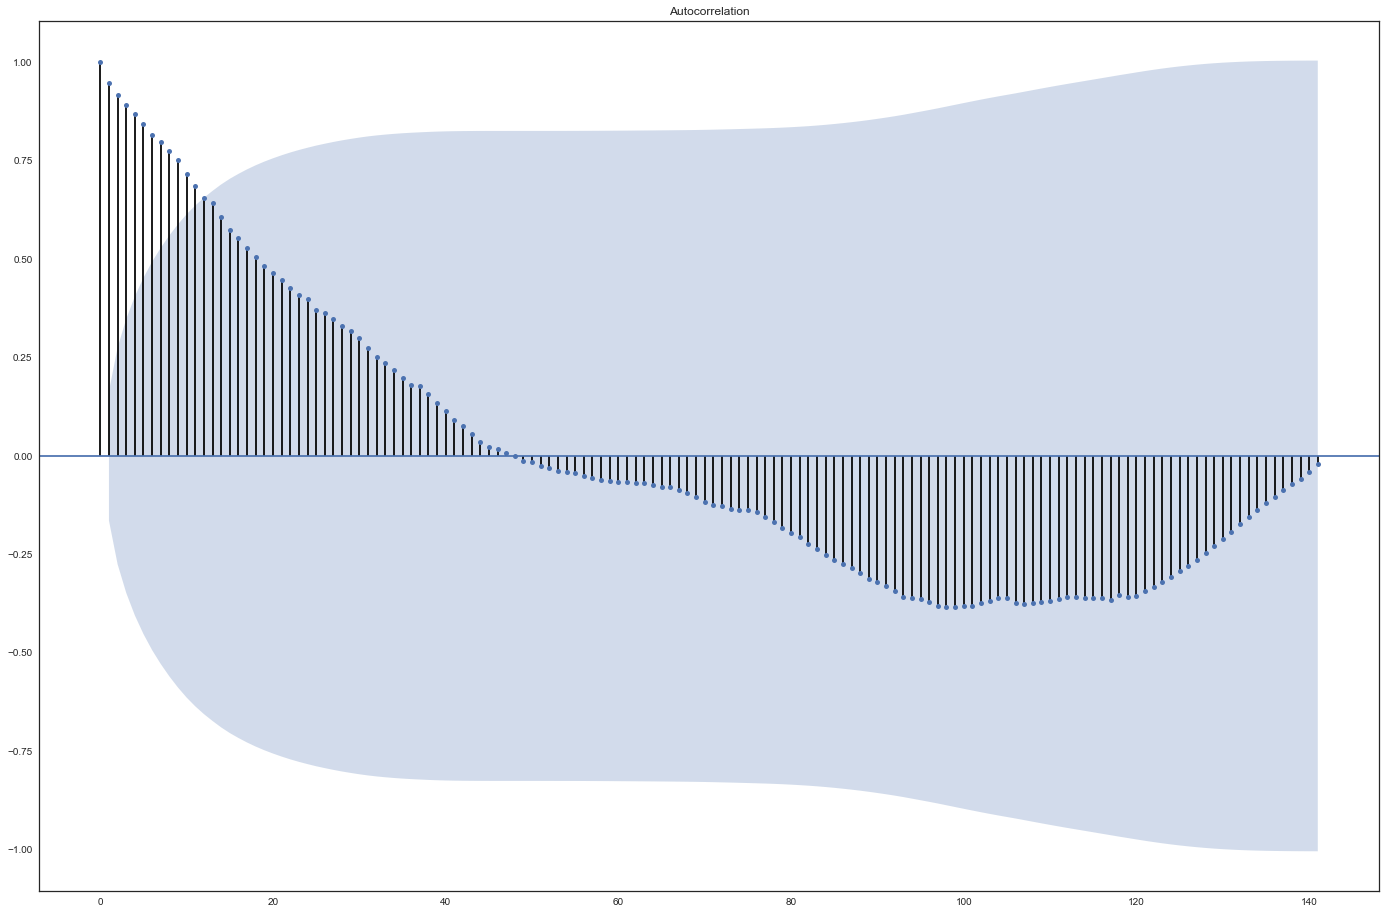

In [193]:
fig, ax = plt.subplots(figsize = (24, 16))
plot_acf(pitching_year['er'], lags = 141, ax = ax)

plt.show();

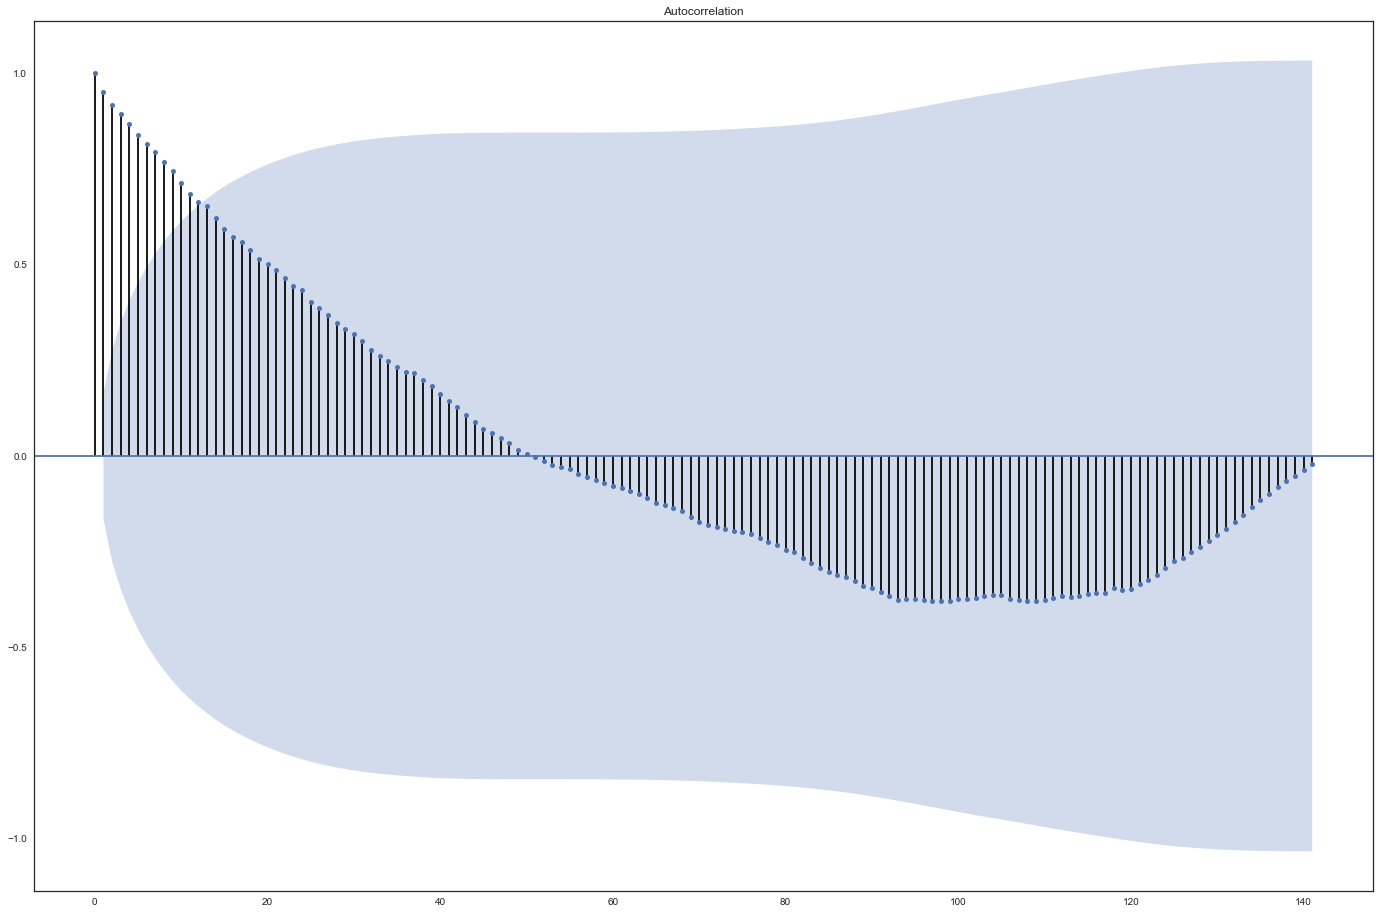

In [194]:
fig, ax = plt.subplots(figsize=(24,16))
plot_acf(pitching_year['bb'], lags=141, ax=ax)
plt.show();

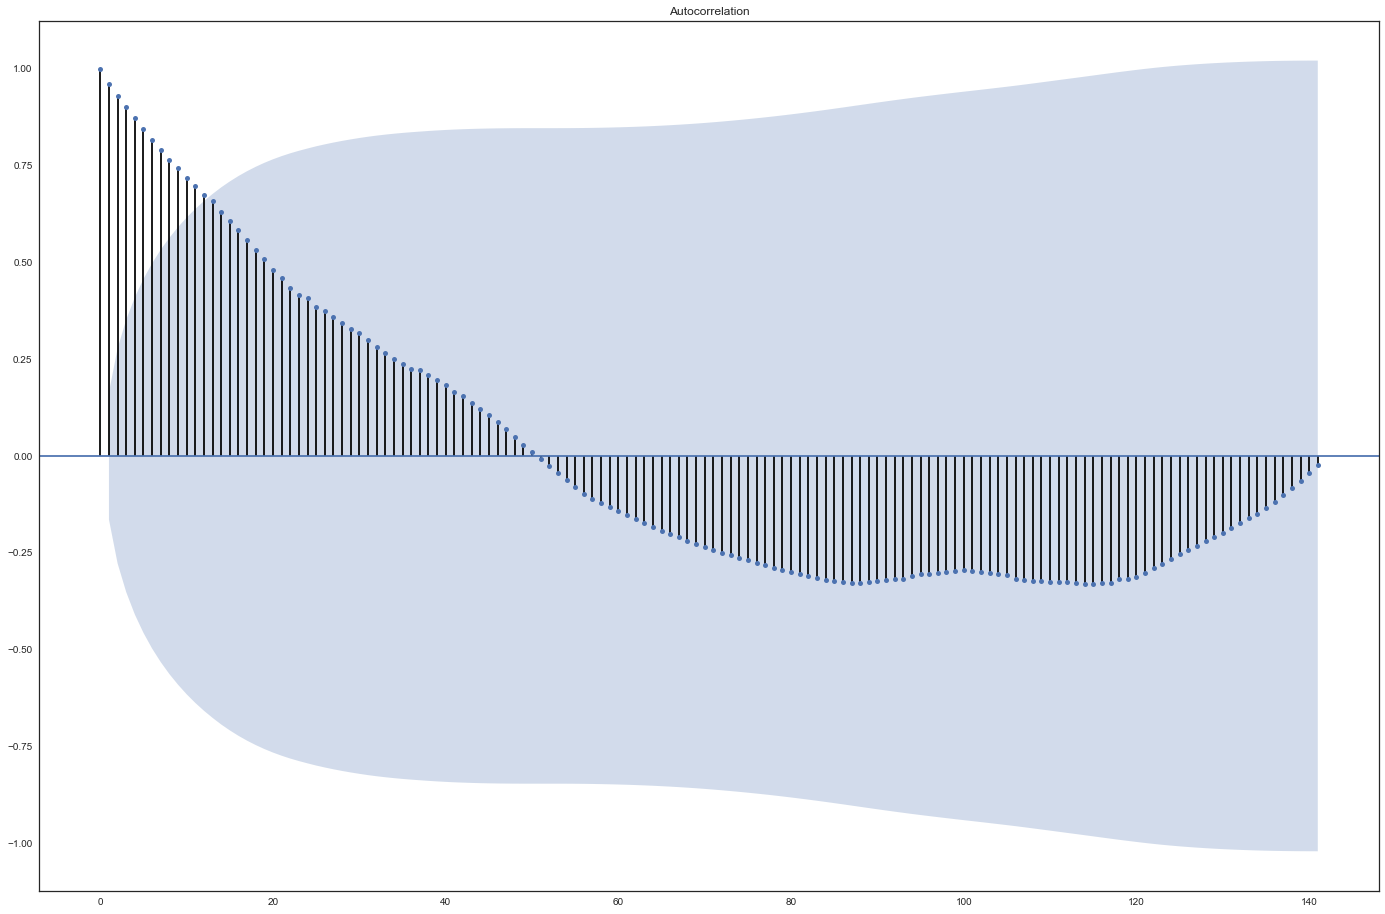

In [195]:
fig, ax =plt.subplots(figsize=(24,16))
plot_acf(pitching_year['so'],lags=141, ax=ax)
plt.show();

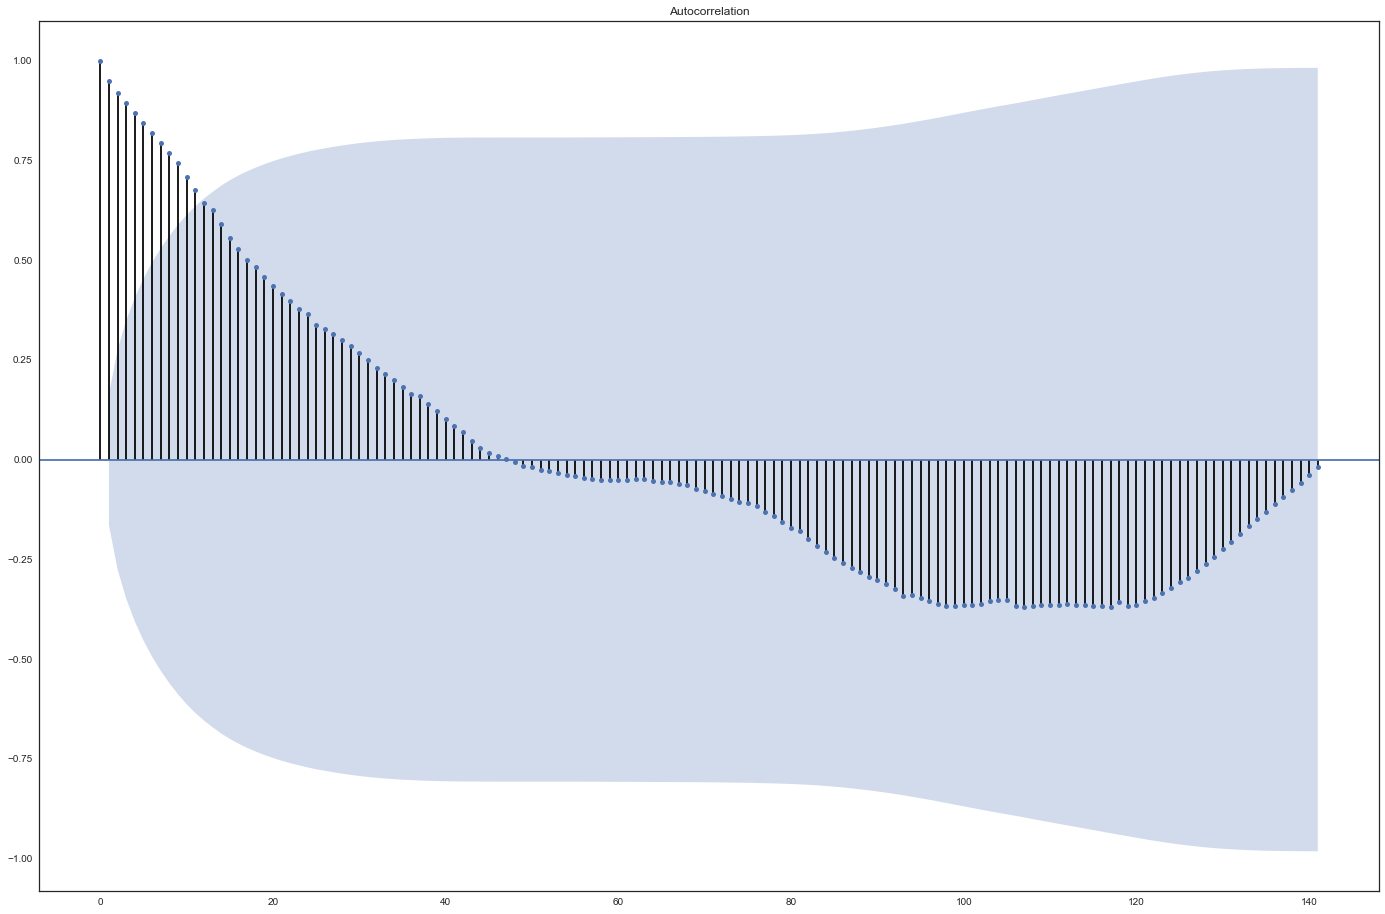

In [196]:
fig,ax=plt.subplots(figsize=(24,16))
plot_acf(pitching_year['h'], lags=141, ax=ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


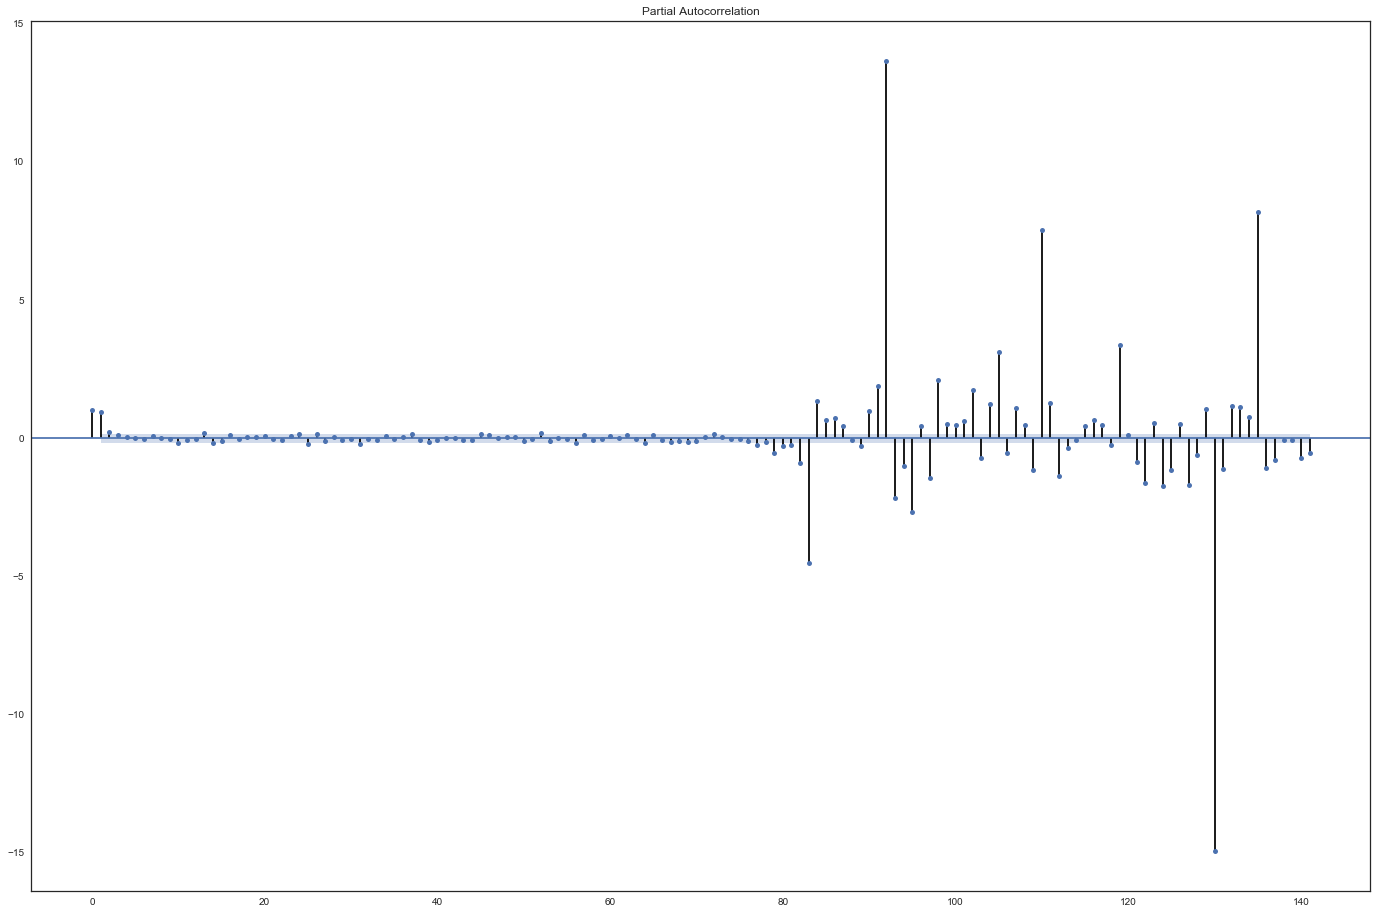

In [197]:
fig, ax = plt.subplots(figsize = (24, 16))
plot_pacf(pitching_year['er'], lags = 141, ax = ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


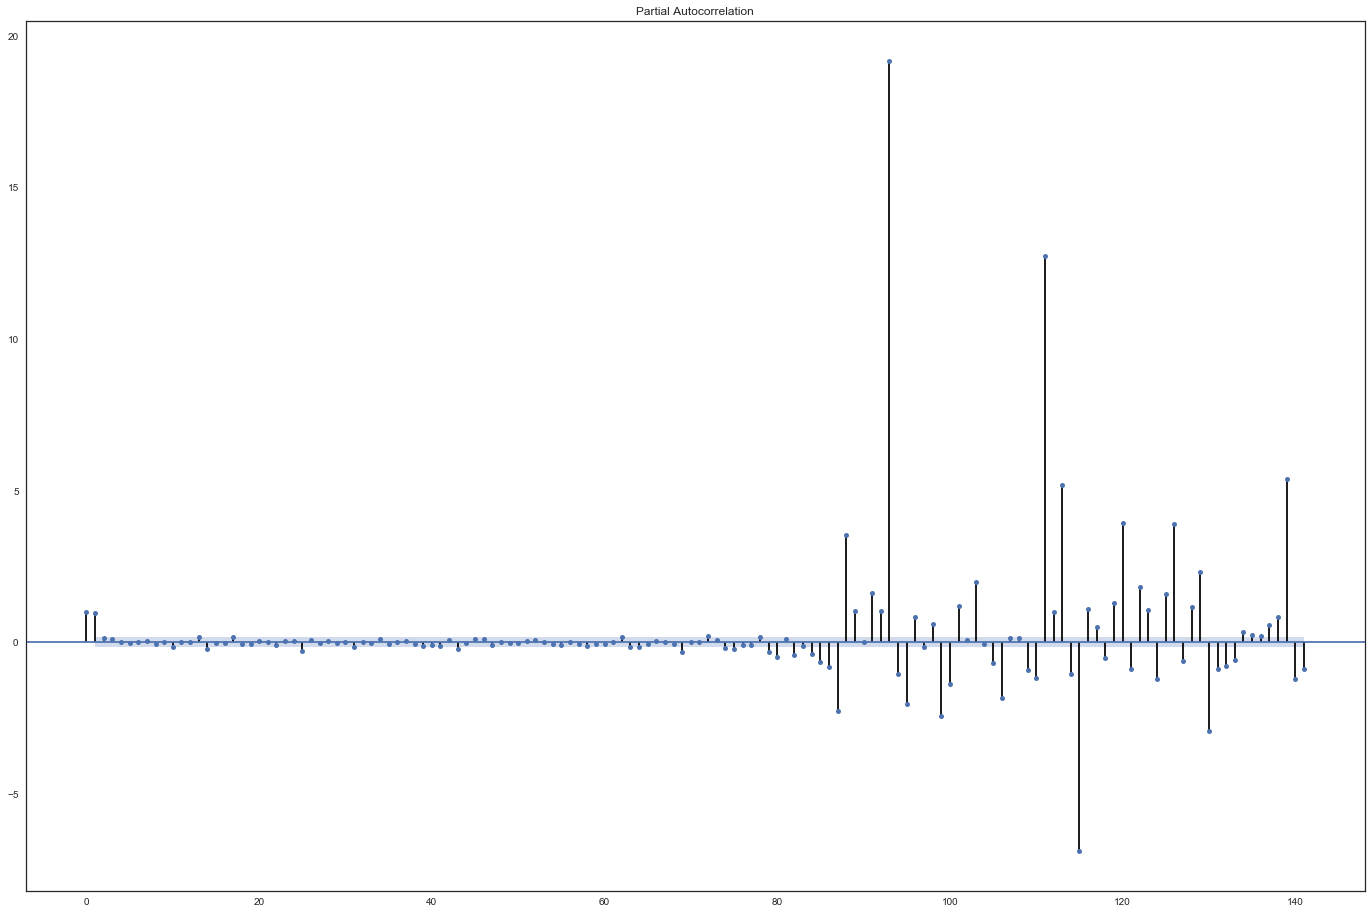

In [198]:
fig, ax = plt.subplots(figsize=(24,16))
plot_pacf(pitching_year['bb'], lags=141, ax=ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


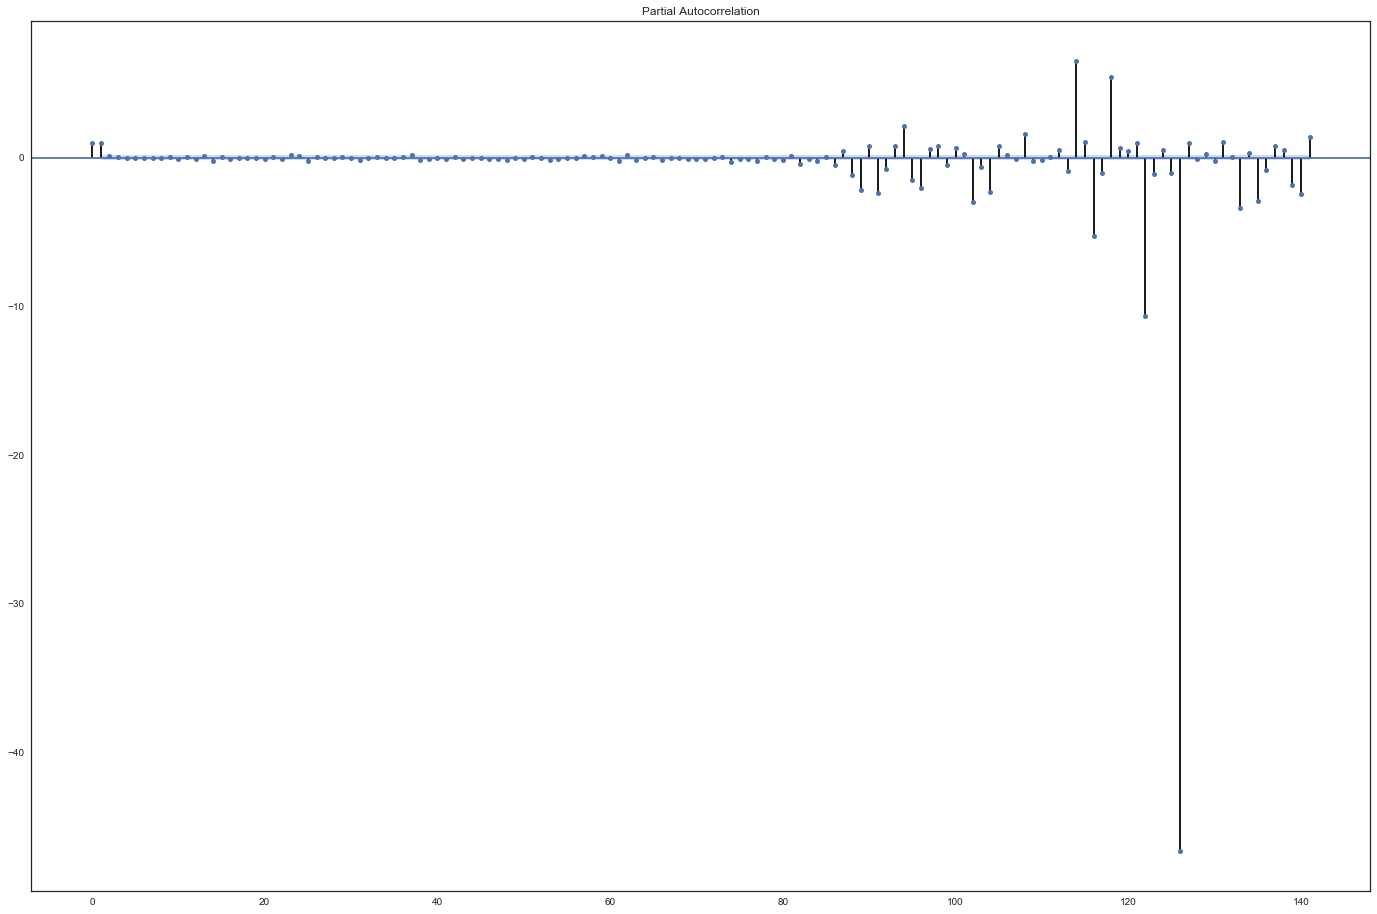

In [200]:
fig,ax = plt.subplots(figsize=(24,16))
plot_pacf(pitching_year['so'], lags=141, ax=ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


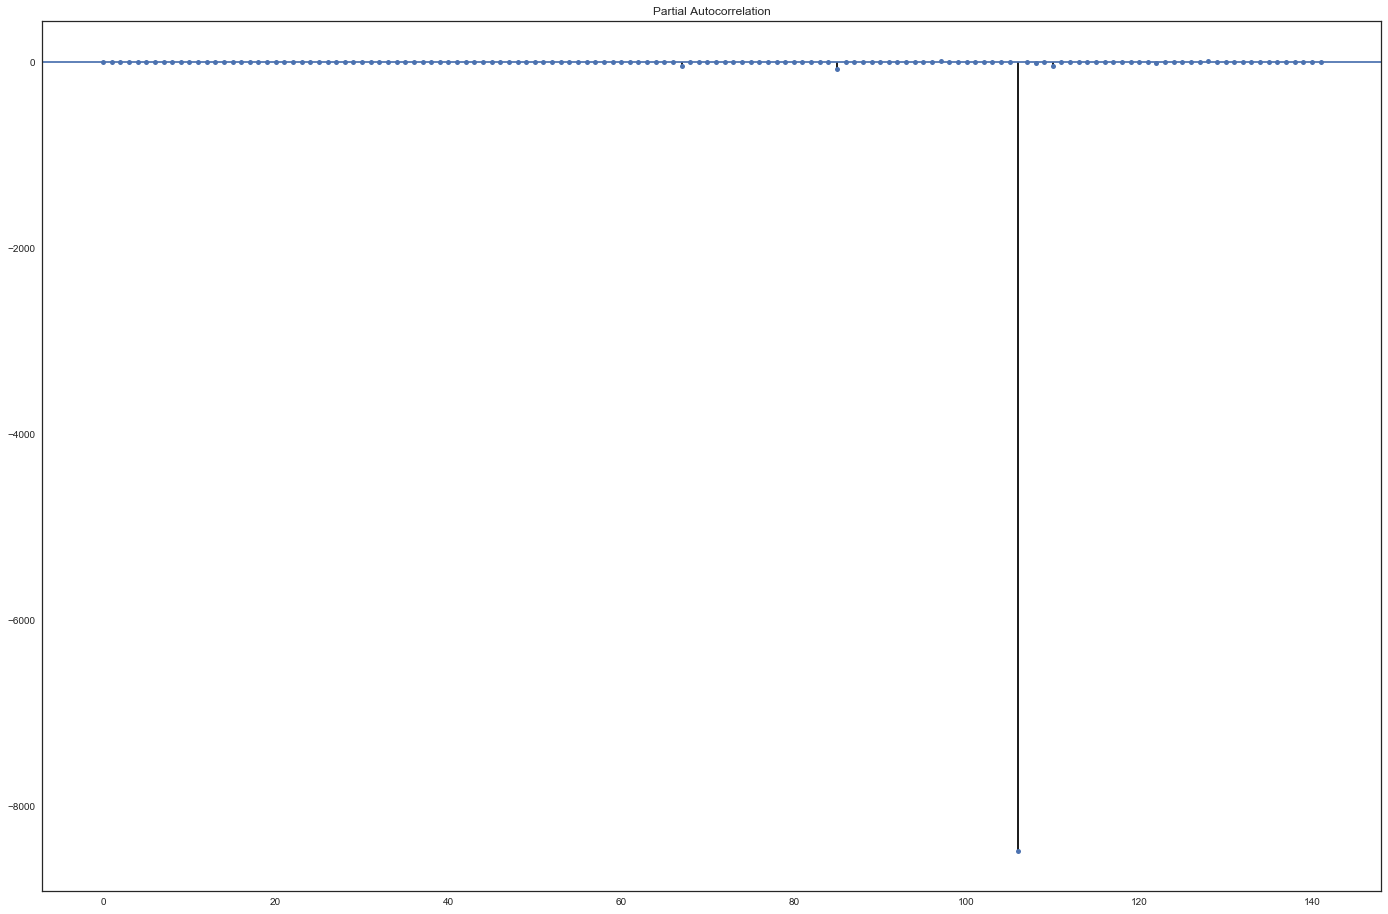

In [201]:
fig,ax=plt.subplots(figsize=(24,16))
plot_pacf(pitching_year['h'], lags=141, ax=ax)
plt.show();

### in a loop

In [202]:
for i in range(1,5):
    ar = ARMA(endog = pitching_year['er'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds,
                                                                              pitching_year['er'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.9100247711772108
AR(2) returns an R-squared value of: 0.918644175973248
AR(3) returns an R-squared value of: 0.9196748022119137
AR(4) returns an R-squared value of: 0.9206433268866397


In [203]:
r2_score(preds[4:], pitching_year['er'][4:]) # skips first 4 lines that are always off because no correlated value

0.9395040180944882

In [204]:
for i in range(1,5):
    ar = ARMA(endog = pitching_year['bb'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds,
                                                                              pitching_year['bb'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.9170756738284912
AR(2) returns an R-squared value of: 0.922504615138344
AR(3) returns an R-squared value of: 0.9247733055932137
AR(4) returns an R-squared value of: 0.9255095817194152


In [205]:
r2_score(preds[4:], pitching_year['bb'][4:]) # skips first 4 lines that are always off because no correlated value

0.9437895874747071

In [206]:
for i in range(1,5):
    ar = ARMA(endog = pitching_year['so'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds,
                                                                              pitching_year['so'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.9606627026740356
AR(2) returns an R-squared value of: 0.9624916281850056
AR(3) returns an R-squared value of: 0.9624692705483312
AR(4) returns an R-squared value of: 0.9627613846953614


In [207]:
r2_score(preds[4:], pitching_year['so'][4:]) # skips first 4 lines that are always off because no correlated value

0.975487796657784

In [208]:
for i in range(1,5):
    ar = ARMA(endog = pitching_year['h'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds,
                                                                              pitching_year['h'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.9106501421079225
AR(2) returns an R-squared value of: 0.9208744206361855
AR(3) returns an R-squared value of: 0.9249580314351168
AR(4) returns an R-squared value of: 0.9266504577896244


In [209]:
r2_score(preds[4:], pitching_year['h'][4:]) # skips first 4 lines that are always off because no correlated value

0.9431966529179242

### Predicted Earned Runs

In [210]:
ar_p_er = ARMA(endog = pitching_year['er'], # y variable
          order= (2,0))  # (p,q) <--- talk about q later

In [211]:
model = ar_p_er.fit()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

In [212]:
preds = model.predict() #generated prediction values. Since autoregression, don't have to pass anything into model

In [213]:
r2_score(preds, pitching_year['er'])

0.918644175973248

In [214]:
pitching_year['predicted'] = preds
pitching_year[['er', 'predicted']].head(10)

,er,predicted
1876-12-31,1113,10166.986765
1877-12-31,970,1269.276823
1878-12-31,743,1123.981102
1879-12-31,1513,925.129566
1880-12-31,1452,1384.198588
1881-12-31,1666,1575.368077
1882-12-31,1830,1703.585353
1883-12-31,2224,1880.739585
1884-12-31,2298,2200.405636
1885-12-31,2178,2370.337028


In [215]:
pitching_year[['er', 'predicted']].tail(10)

,er,predicted
2008-12-31,19190,19794.381085
2009-12-31,19001,19289.548366
2010-12-31,18506,18951.841427
2011-12-31,17731,18555.386491
2012-12-31,18009,17874.435402
2013-12-31,17414,17830.483252
2014-12-31,16686,17506.788968
2015-12-31,17512,16827.794390
2016-12-31,18514,17173.658128
2017-12-31,19206,18110.343800


In [216]:
np.mean(pitching_year['predicted'])

10361.758345975566

In [217]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                     er   No. Observations:                  142
Model:                     ARMA(2, 0)   Log Likelihood               -1216.356
Method:                       css-mle   S.D. of innovations           1254.368
Date:                Wed, 17 Oct 2018   AIC                           2440.711
Time:                        21:51:07   BIC                           2452.535
Sample:                    12-31-1876   HQIC                          2445.516
                         - 12-31-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.017e+04   5522.836      1.841      0.068    -657.573     2.1e+04
ar.L1.er       0.6854      0.080      8.608      0.000       0.529       0.841
ar.L2.er       0.3026      0.080      3.768      0.0

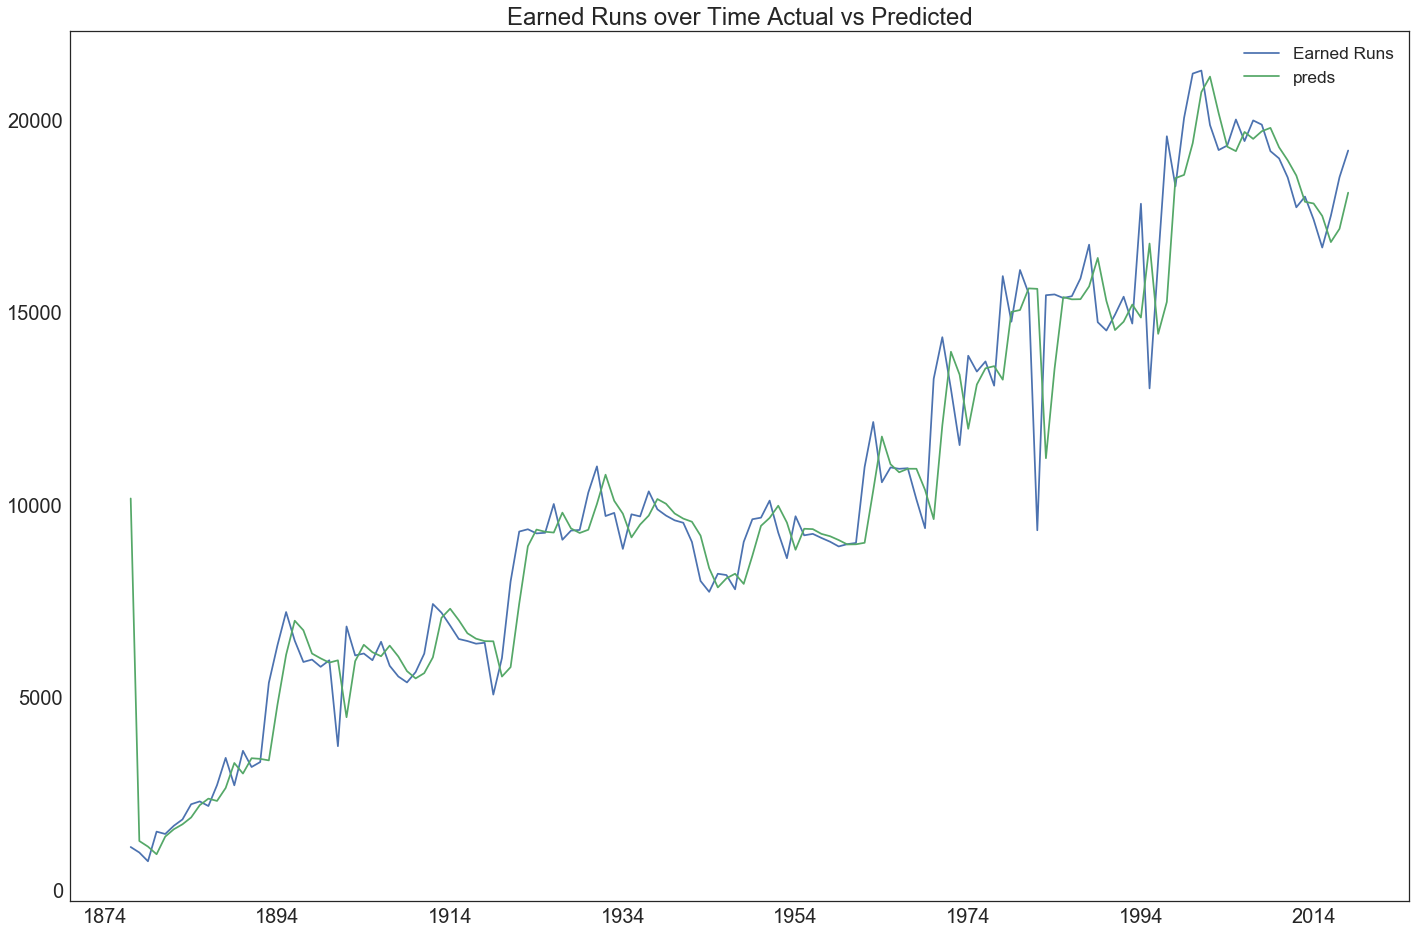

In [218]:
plt.figure(figsize=(24,16))
plt.plot(pitching_year['er'], label='Earned Runs')
plt.plot(preds, label='preds')
plt.title('Earned Runs over Time Actual vs Predicted', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize='xx-large');

## forecasting

In [219]:
forecast_p_er = model.forecast(steps=1, # number of out of sample forecast
               exog=None, # only applies if armax
               alpha=0.05 # confidence intervals of the forecast
              )

# returns forecast, std err, and confidence interval range

In [220]:
forecast_p_er

(array([18887.80999046]),
 array([1254.3683399]),
 array([[16429.29322091, 21346.32676001]]))

In [221]:
forecast_p_er[0]

array([18887.80999046])

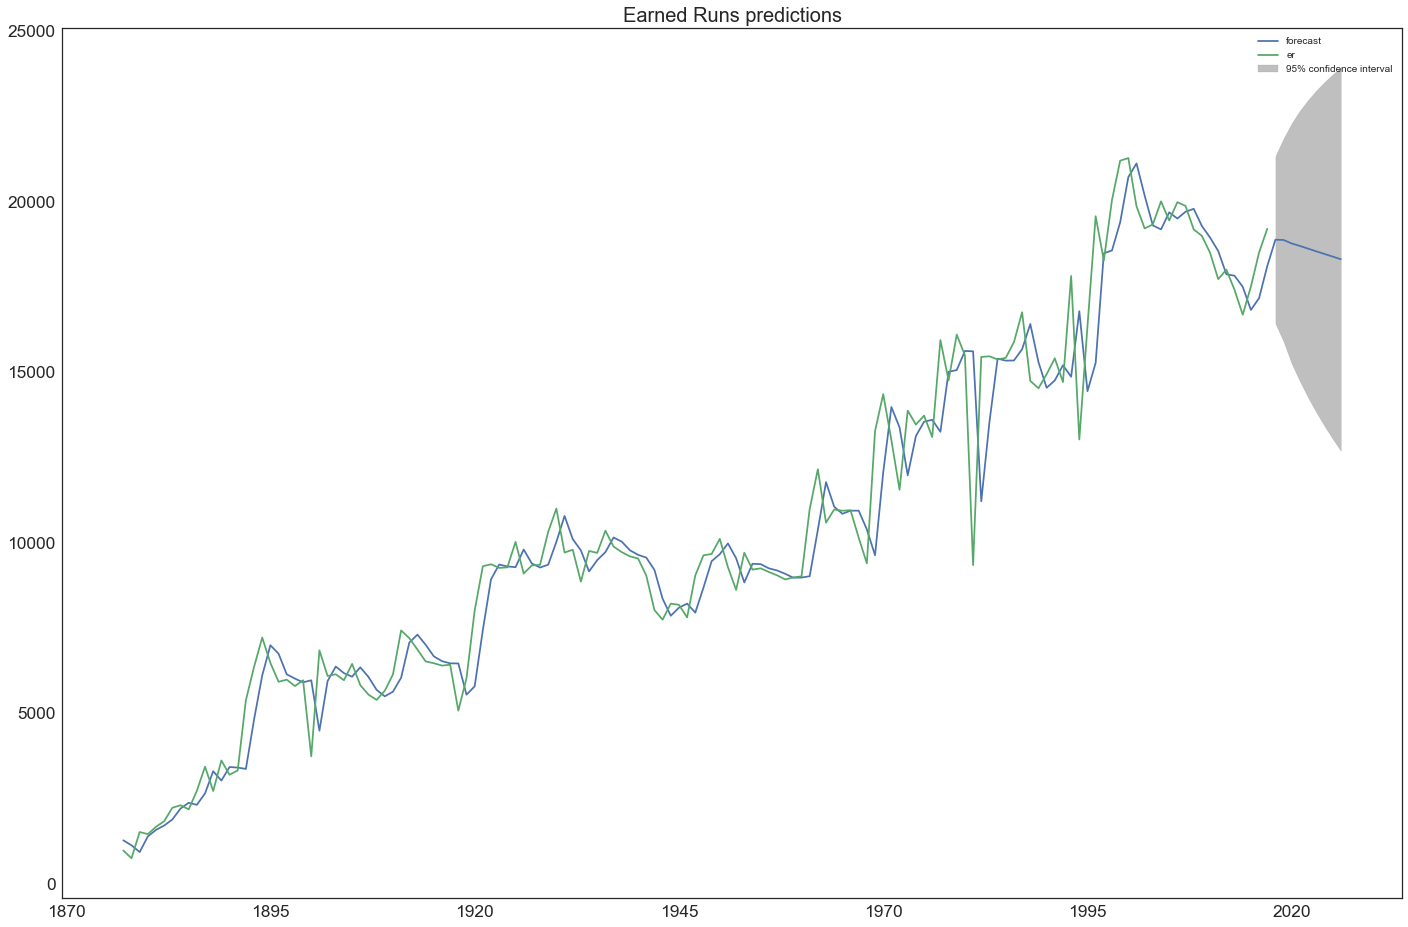

In [222]:
fig, ax = plt.subplots(figsize = (24, 16))
ax.set_title('Earned Runs predictions', fontsize=20)
ax.tick_params(labelsize='xx-large')
model.plot_predict(start=1, end=150, alpha=0.05, ax = ax)

plt.show();

### Doubleplays

In [287]:
ar_p_so = ARMA(endog = pitching_year['so'], # y variable
          order= (2,0))  # (p,q) <--- talk about q later

In [288]:
model = ar_p_so.fit()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

In [289]:
preds = model.predict() #generated prediction values. Since autoregression, don't have to pass anything into model

In [291]:
r2_score(preds, pitching_year['so'])

0.9624916281850056

In [292]:
pitching_year['predicted'] = preds
pitching_year[['so', 'predicted']].head(10)

,so,predicted
1876-12-31,571,14014.786318
1877-12-31,702,624.123171
1878-12-31,977,701.379988
1879-12-31,1757,933.864076
1880-12-31,1914,1565.280587
1881-12-31,1718,1902.441958
1882-12-31,2105,1809.323355
1883-12-31,2779,2026.231149
1884-12-31,4065,2615.141271
1885-12-31,3120,3720.119640


In [293]:
pitching_year[['so', 'predicted']].tail(10)

,so,predicted
2008-12-31,31330,30443.545104
2009-12-31,31810,31087.476633
2010-12-31,33072,31620.919098
2011-12-31,32898,32652.683390
2012-12-31,34829,32895.454696
2013-12-31,35073,34210.816363
2014-12-31,35643,34943.177330
2015-12-31,35465,35417.073538
2016-12-31,37184,35456.411258
2017-12-31,38021,36620.665065


In [294]:
np.mean(pitching_year['predicted'])

13771.561837179761

In [295]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                     so   No. Observations:                  142
Model:                     ARMA(2, 0)   Log Likelihood               -1241.908
Method:                       css-mle   S.D. of innovations           1494.019
Date:                Thu, 18 Oct 2018   AIC                           2491.816
Time:                        09:52:20   BIC                           2503.640
Sample:                    12-31-1876   HQIC                          2496.621
                         - 12-31-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.401e+04   1.76e+04      0.795      0.428   -2.05e+04    4.86e+04
ar.L1.so       0.7073      0.080      8.827      0.000       0.550       0.864
ar.L2.so       0.2899      0.080      3.609      0.0

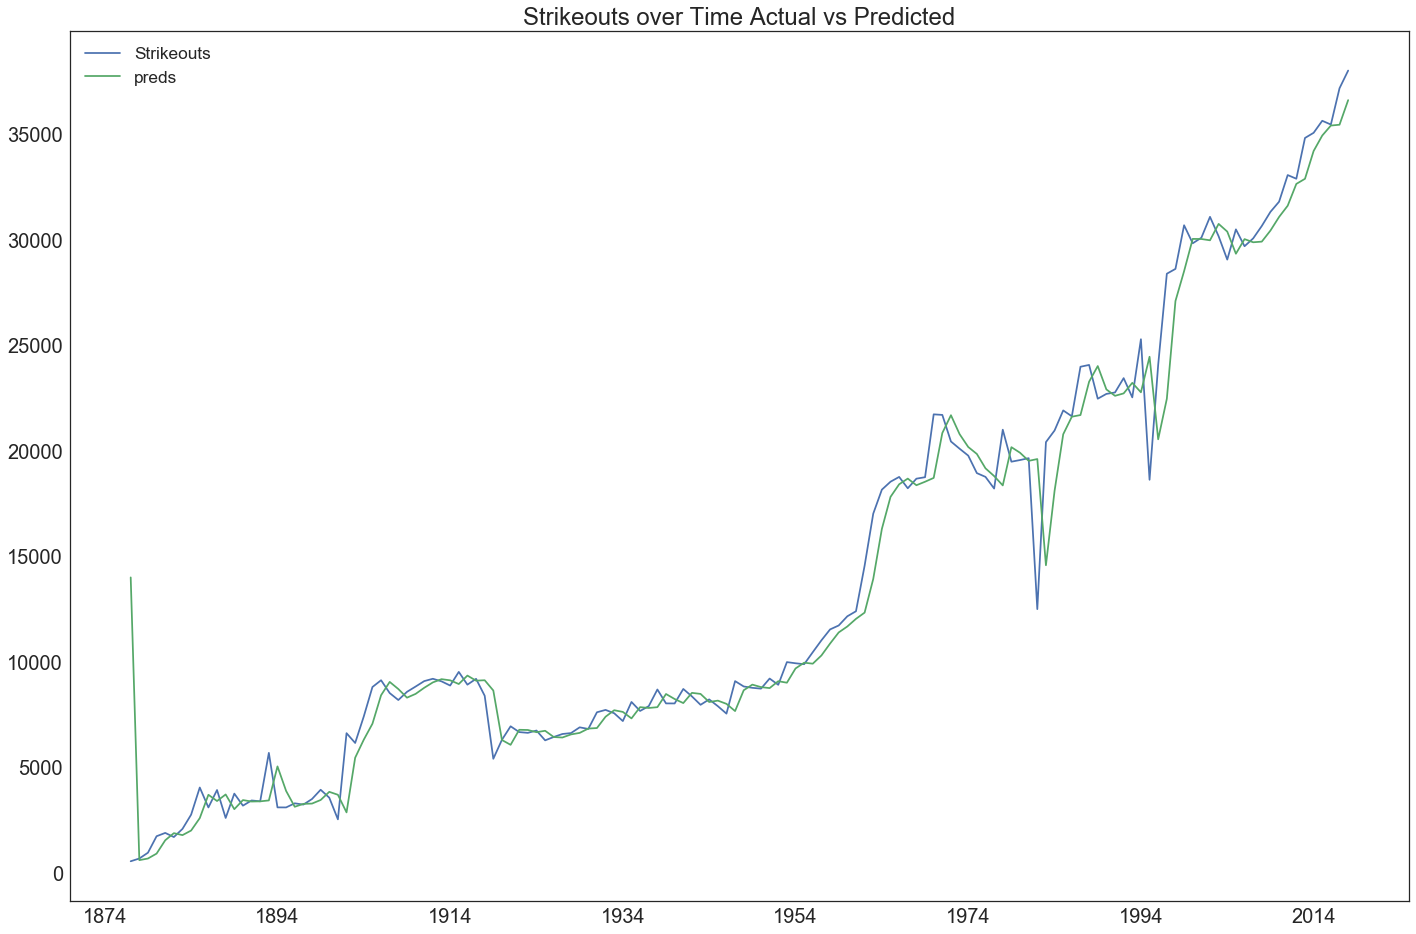

In [296]:
plt.figure(figsize=(24,16))
plt.plot(pitching_year['so'], label='Strikeouts')
plt.plot(preds, label='preds')
plt.title('Strikeouts over Time Actual vs Predicted', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize='xx-large');

## forecasting

In [297]:
forecast_p_so = model.forecast(steps=1, # number of out of sample forecast
               exog=None, # only applies if armax
               alpha=0.05 # confidence intervals of the forecast
              )

# returns forecast, std err, and confidence interval range

In [298]:
forecast_p_so

(array([37711.00005138]),
 array([1494.01886542]),
 array([[34782.77688294, 40639.22321983]]))

In [299]:
forecast_p_so[0]

array([37711.00005138])

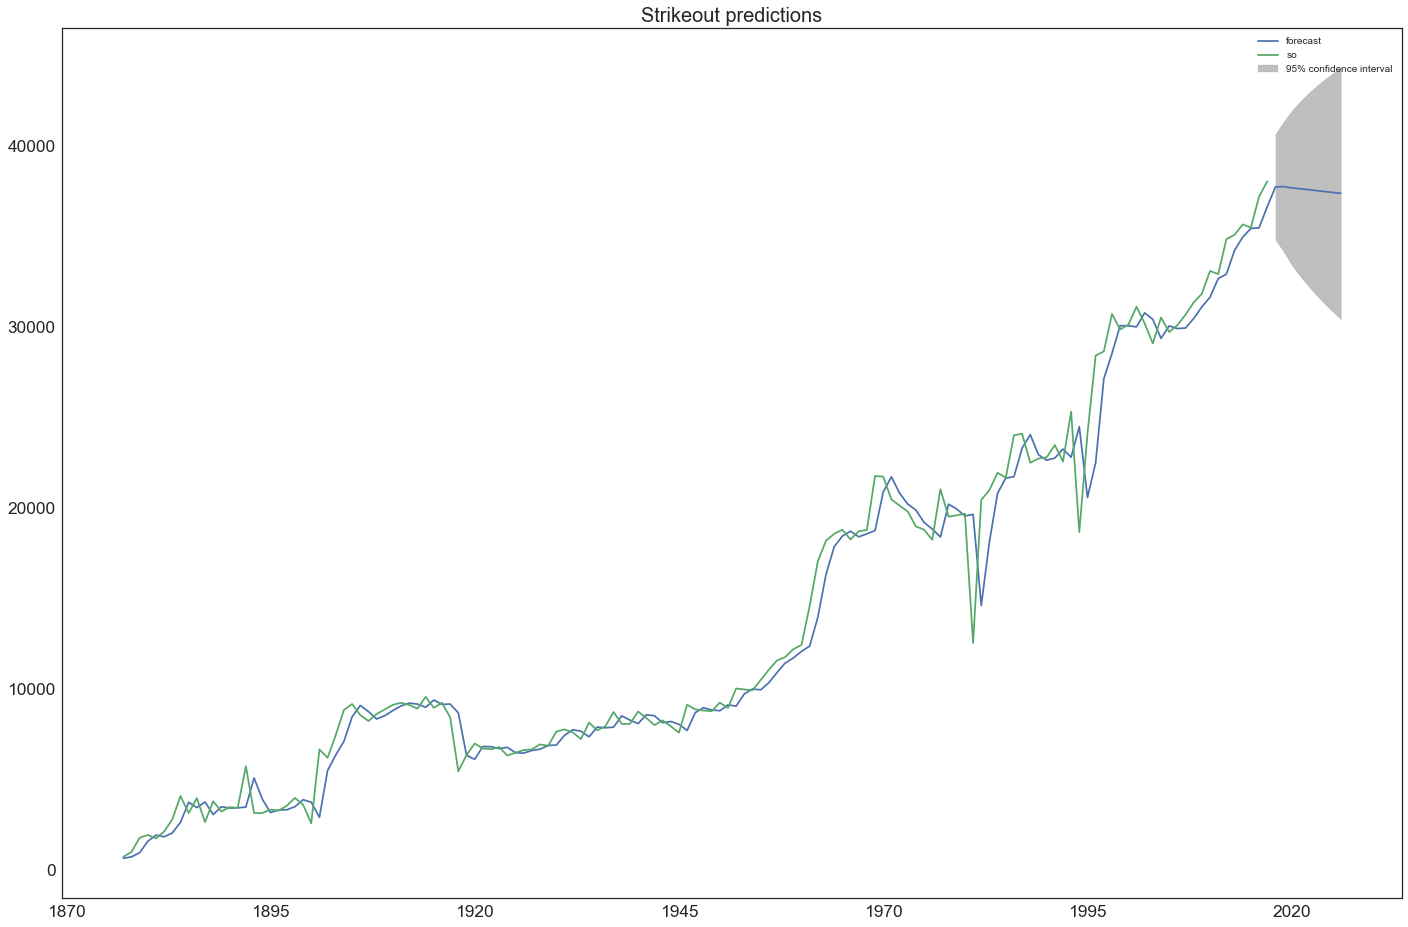

In [300]:
fig, ax = plt.subplots(figsize = (24, 16))
ax.set_title('Strikeout predictions', fontsize=20)
ax.tick_params(labelsize='xx-large')
model.plot_predict(start=1, end=150, alpha=0.05, ax = ax)

plt.show();

### Fielding

In [237]:
fielding_year.index

Int64Index([1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885,
            ...
            2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
           dtype='int64', name='year', length=142)

In [238]:
fielding_year['year'] = fielding_year.index

In [239]:
fielding_year.index = pd.date_range('1876', #start date
                         periods = len(fielding_year.index), #we want the number 
                         freq = 'Y') # each period should last one month

In [240]:
fielding_year.columns

Index(['g', 'gs', 'innouts', 'po', 'a', 'e', 'dp', 'pb', 'sb', 'cs', 'fp%',
       'period', 'rf/g', 'year'],
      dtype='object')

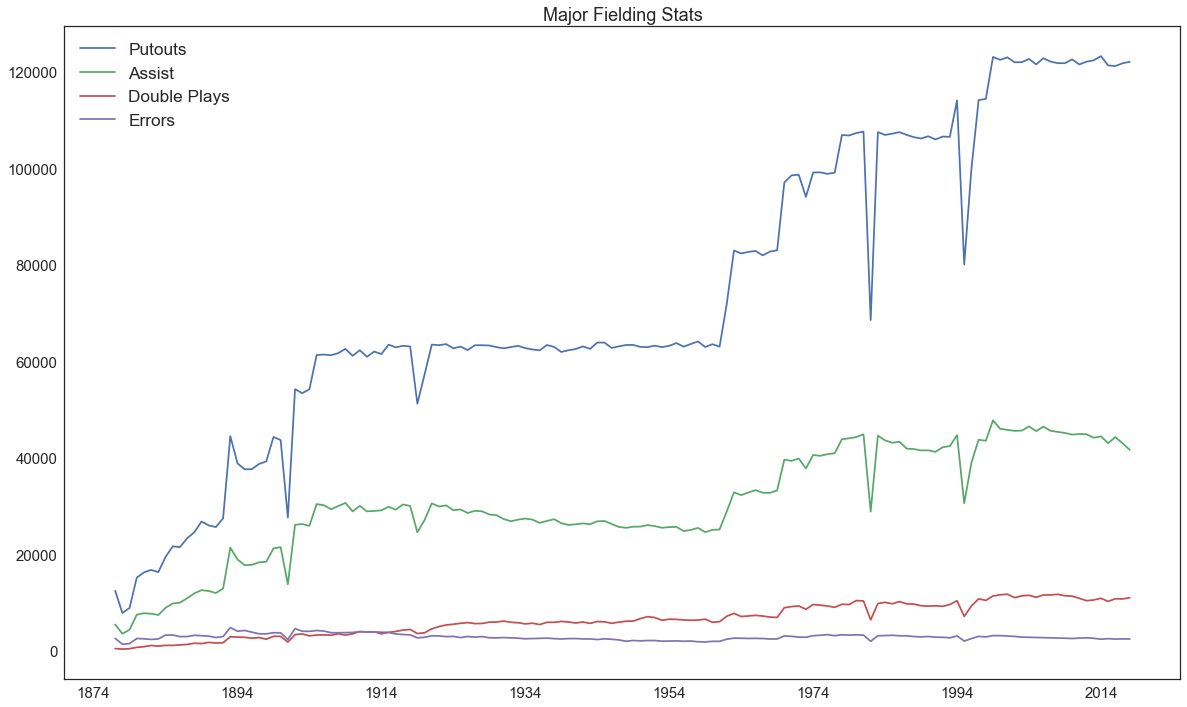

In [242]:
plt.figure(figsize = (20, 12))
plt.plot(fielding_year['po'], label='Putouts')
# sns.regplot(x=pitching_year['year'], y=pitching_year['er'],
#              scatter=False, logistic=False, order=1)
plt.plot(fielding_year['a'], label='Assist')
# sns.regplot(x=pitching_year['year'], y=pitching_year['bb'],
#             scatter=False, logistic=False, order=1)
plt.plot(fielding_year['dp'], label='Double Plays')
plt.plot(fielding_year['e'], label='Errors')
plt.title(s = "Major Fielding Stats", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(axis='both', which='both', direction='inout')
plt.legend(fontsize='xx-large')
plt.show();

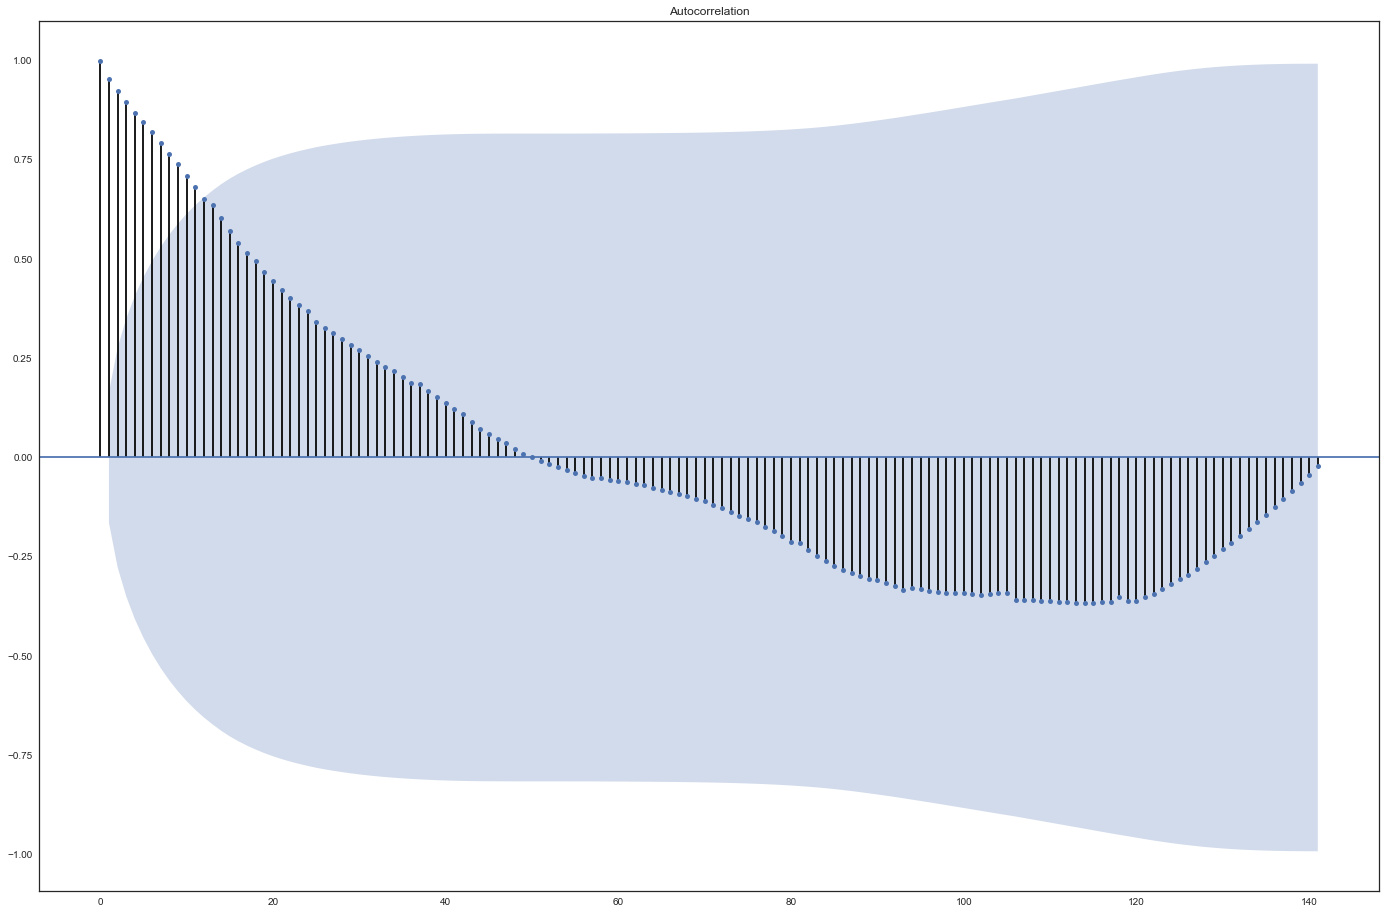

In [243]:
fig, ax = plt.subplots(figsize = (24, 16))
plot_acf(fielding_year['po'], lags = 141, ax = ax)

plt.show();

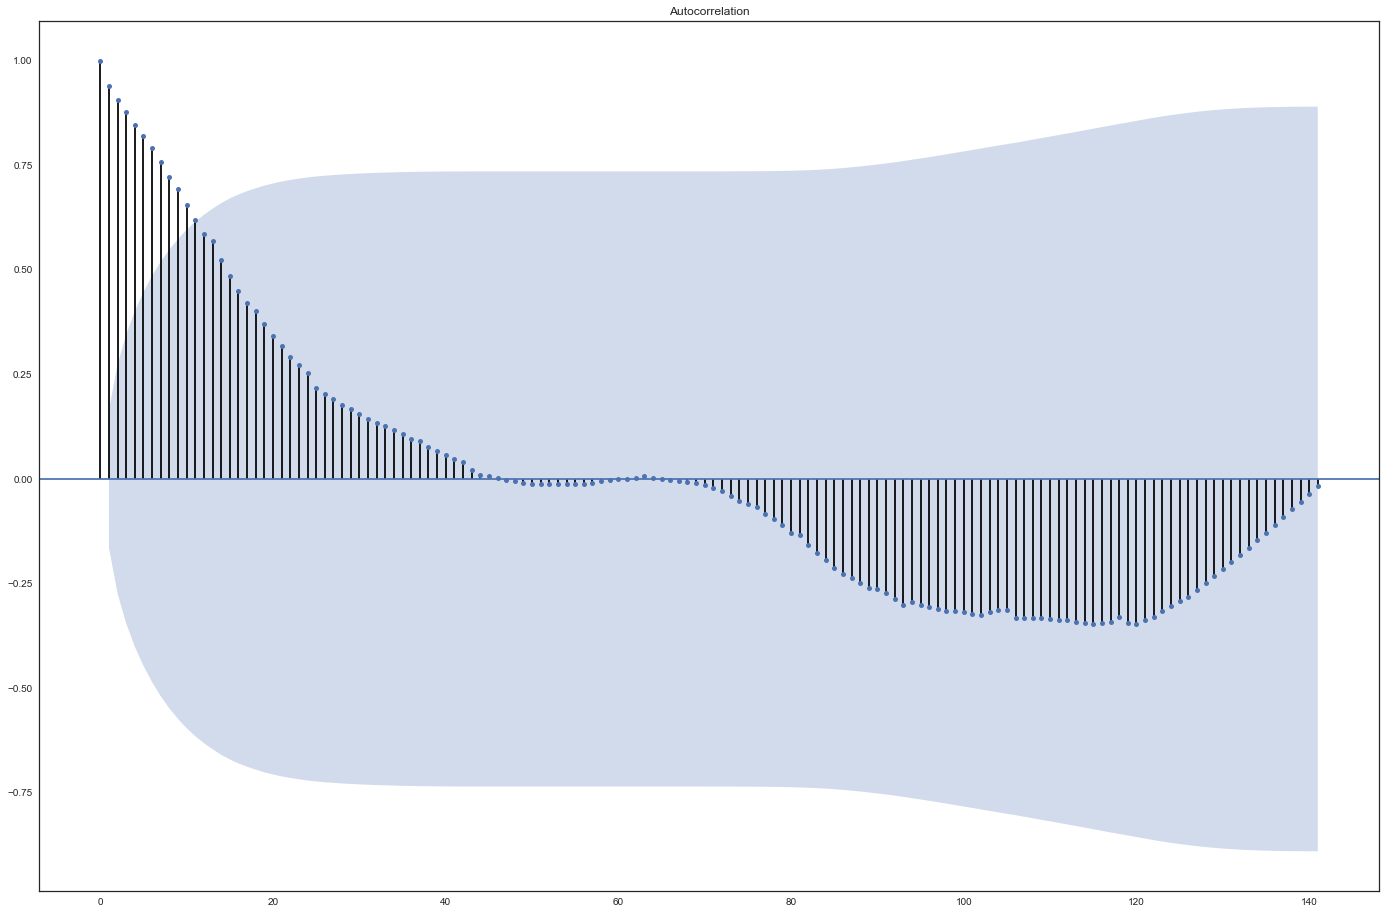

In [244]:
fig, ax = plt.subplots(figsize=(24,16))
plot_acf(fielding_year['a'], lags=141, ax=ax)
plt.show();

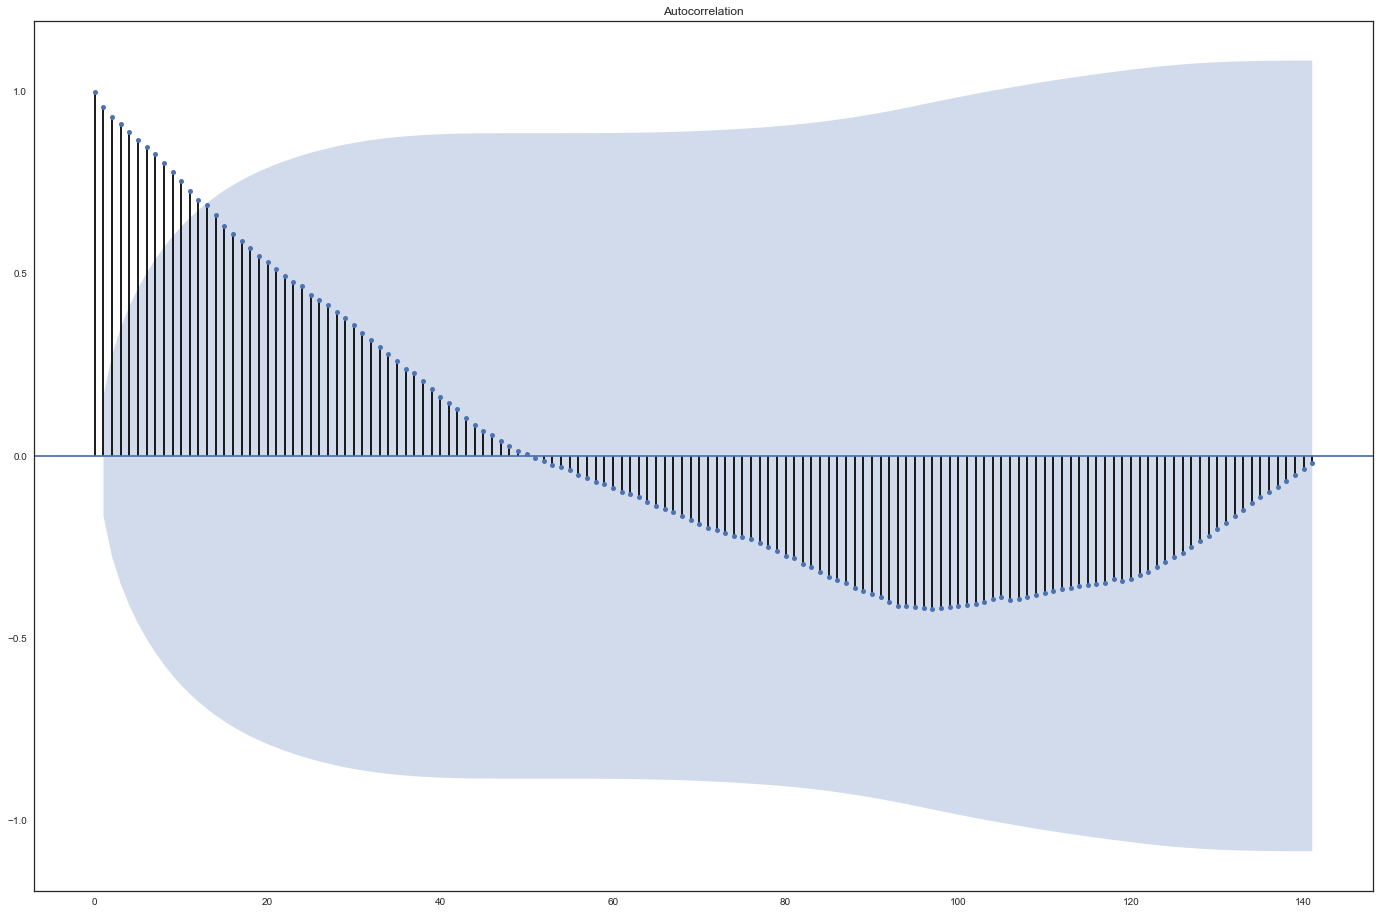

In [245]:
fig, ax =plt.subplots(figsize=(24,16))
plot_acf(fielding_year['dp'],lags=141, ax=ax)
plt.show();

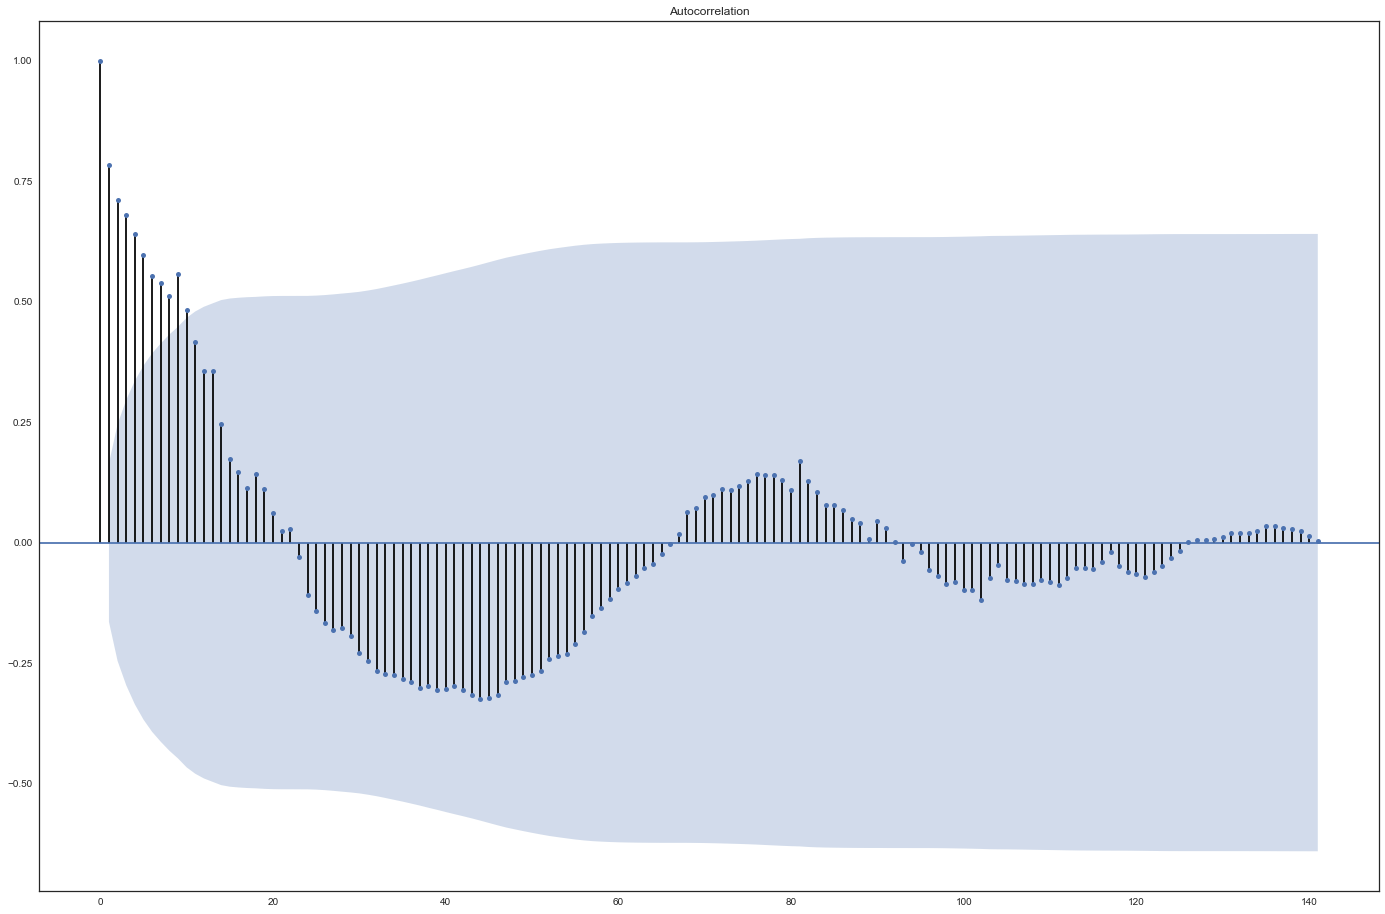

In [246]:
fig,ax=plt.subplots(figsize=(24,16))
plot_acf(fielding_year['e'], lags=141, ax=ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


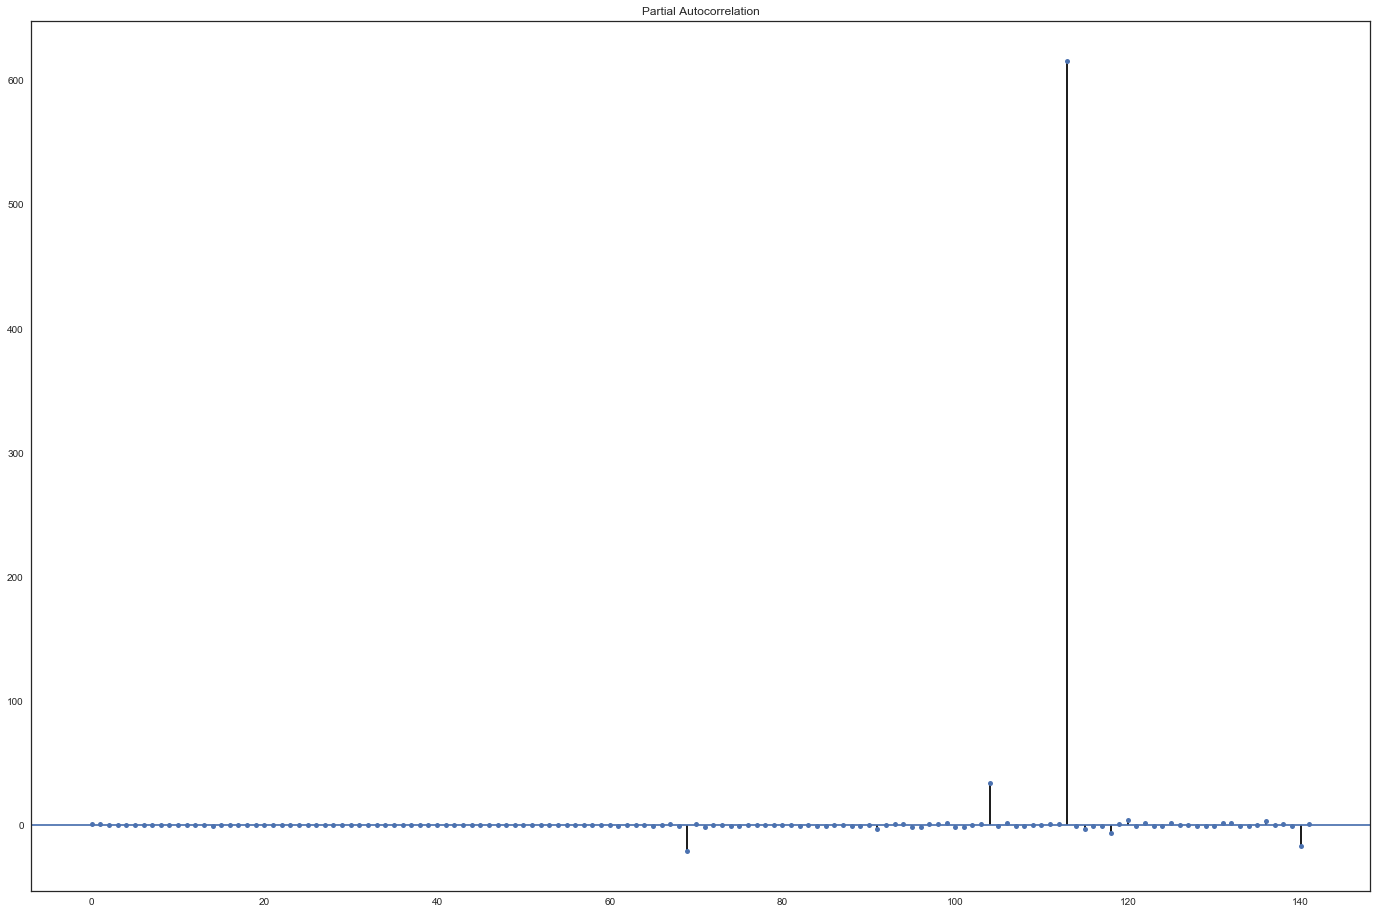

In [247]:
fig, ax = plt.subplots(figsize = (24, 16))
plot_pacf(fielding_year['po'], lags = 141, ax = ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


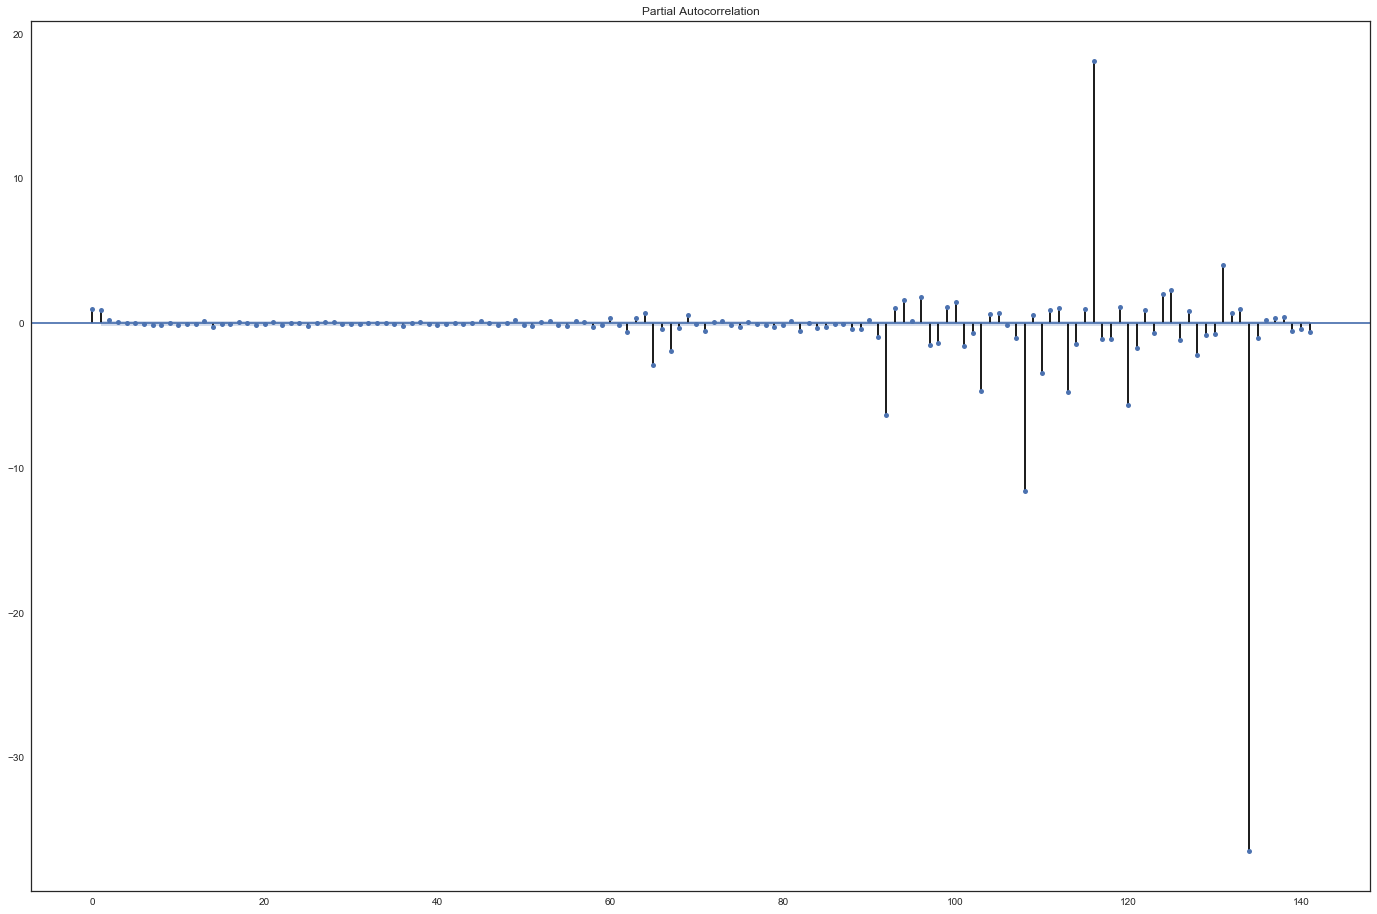

In [248]:
fig, ax = plt.subplots(figsize=(24,16))
plot_pacf(fielding_year['a'], lags=141, ax=ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


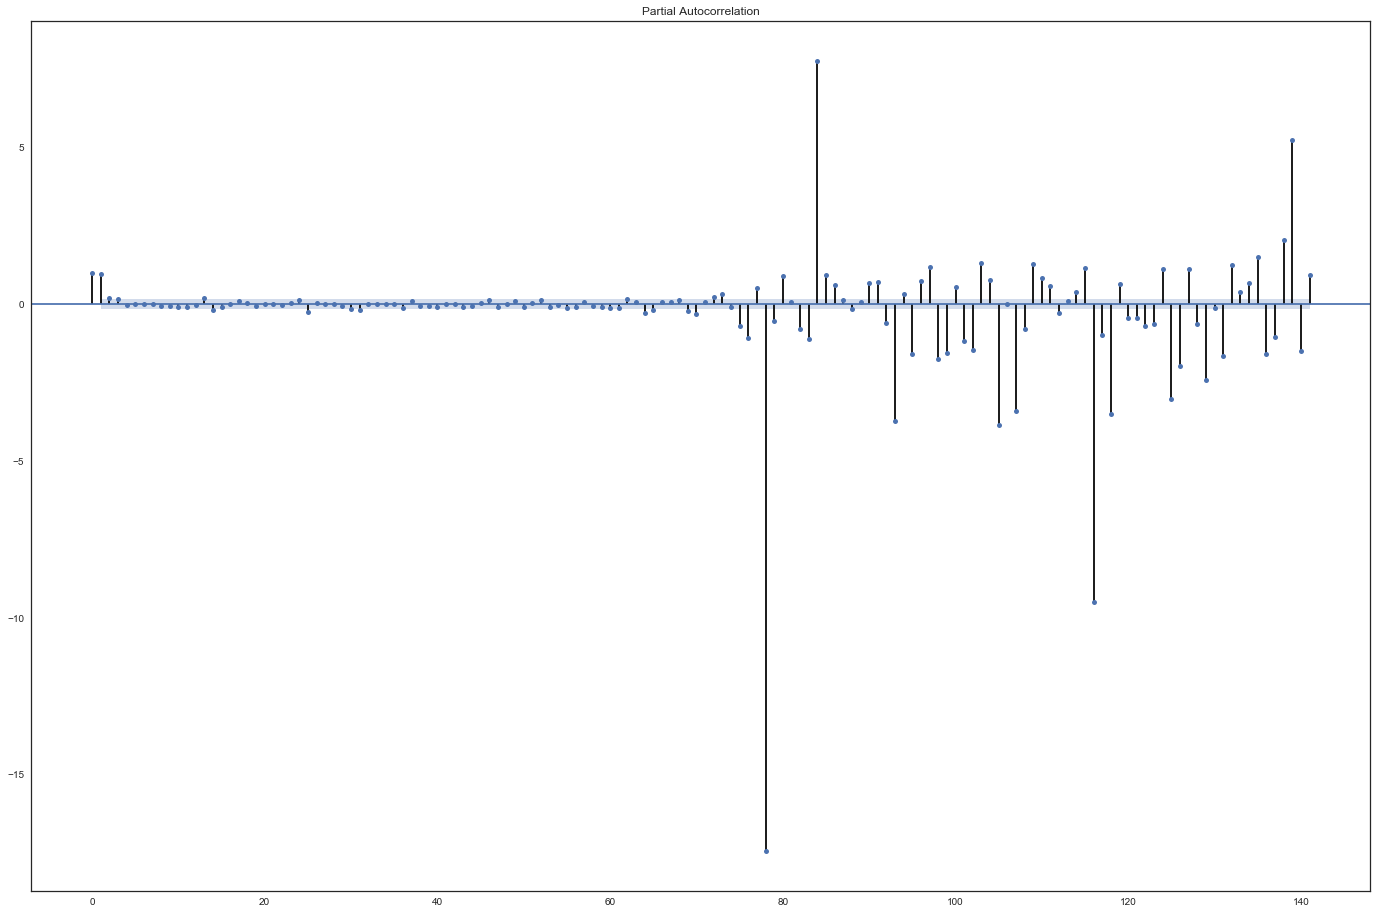

In [249]:
fig,ax = plt.subplots(figsize=(24,16))
plot_pacf(fielding_year['dp'], lags=141, ax=ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


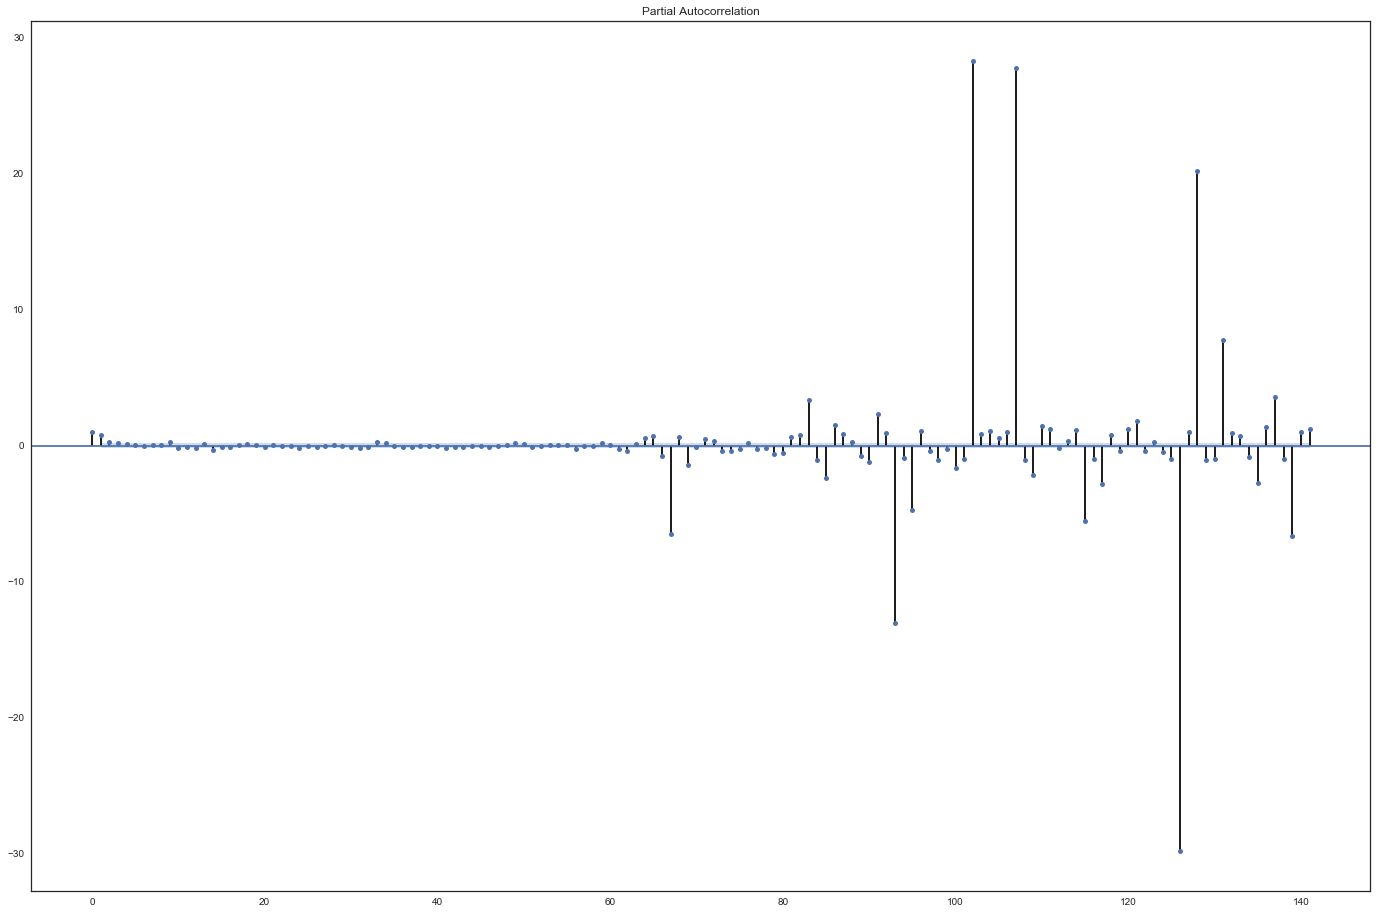

In [250]:
fig,ax=plt.subplots(figsize=(24,16))
plot_pacf(fielding_year['e'], lags=141, ax=ax)
plt.show();

### in a loop

In [251]:
for i in range(1,5):
    ar = ARMA(endog = fielding_year['po'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds,
                                                                              fielding_year['po'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.8942525062951132


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AR(2) returns an R-squared value of: 0.8869624816645799


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AR(3) returns an R-squared value of: 0.8529179002966866
AR(4) returns an R-squared value of: 0.8557814696014926


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [252]:
r2_score(preds[4:], fielding_year['po'][4:]) # skips first 4 lines that are always off because no correlated value

0.954045220765276

In [253]:
for i in range(1,5):
    ar = ARMA(endog = fielding_year['a'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds,
                                                                              fielding_year['a'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.888903705441291
AR(2) returns an R-squared value of: 0.907545574817702
AR(3) returns an R-squared value of: 0.9087966660792021
AR(4) returns an R-squared value of: 0.8635274308497131


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [254]:
r2_score(preds[4:], fielding_year['a'][4:]) # skips first 4 lines that are always off because no correlated value

0.9301433720790007

In [255]:
for i in range(1,5):
    ar = ARMA(endog = fielding_year['dp'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds,
                                                                              fielding_year['dp'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.929895921794648
AR(2) returns an R-squared value of: 0.9356018465498184
AR(3) returns an R-squared value of: 0.9405104655254577
AR(4) returns an R-squared value of: 0.942715500983024


In [256]:
r2_score(preds[4:], fielding_year['dp'][4:]) # skips first 4 lines that are always off because no correlated value

0.9580834466967215

In [257]:
for i in range(1,5):
    ar = ARMA(endog = fielding_year['e'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds,
                                                                              fielding_year['e'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.3700274297166831
AR(2) returns an R-squared value of: 0.44588543265102865
AR(3) returns an R-squared value of: 0.49046388190861256
AR(4) returns an R-squared value of: 0.4960638112152881


In [258]:
r2_score(preds[4:], fielding_year['e'][4:]) # skips first 4 lines that are always off because no correlated value

0.533399037412489

### Putouts

In [259]:
ar_f_po = ARMA(endog = fielding_year['po'], # y variable
          order= (1,0))  # (p,q) <--- talk about q later

In [260]:
model = ar_f_po.fit()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

In [261]:
preds = model.predict() #generated prediction values. Since autoregression, don't have to pass anything into model

In [262]:
r2_score(preds, fielding_year['po'])

0.8942525062951132

In [263]:
fielding_year['predicted'] = preds
fielding_year[['po', 'predicted']].head(10)

,po,predicted
1876-12-31,12497,98987.238905
1877-12-31,7891,13332.027930
1878-12-31,8940,8770.496979
1879-12-31,15218,9809.369312
1880-12-31,16306,16026.757786
1881-12-31,16823,17104.253591
1882-12-31,16366,17616.262167
1883-12-31,19494,17163.674315
1884-12-31,21698,20261.474753
1885-12-31,21549,22444.196033


In [264]:
fielding_year[['po', 'predicted']].tail(10)

,po,predicted
2008-12-31,121769,121557.964510
2009-12-31,122573,121549.051402
2010-12-31,121508,122345.289110
2011-12-31,122088,121290.571250
2012-12-31,122371,121864.971587
2013-12-31,123234,122145.239338
2014-12-31,121309,122999.907425
2015-12-31,121187,121093.492514
2016-12-31,121751,120972.670374
2017-12-31,122055,121531.225184


In [265]:
np.mean(fielding_year['predicted'])

73763.37369525596

In [266]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                     po   No. Observations:                  142
Model:                     ARMA(1, 0)   Log Likelihood               -1462.836
Method:                       css-mle   S.D. of innovations           7106.823
Date:                Thu, 18 Oct 2018   AIC                           2931.673
Time:                        09:25:42   BIC                           2940.540
Sample:                    12-31-1876   HQIC                          2935.276
                         - 12-31-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.899e+04        nan        nan        nan         nan         nan
ar.L1.po       0.9903        nan        nan        nan         nan         nan
                                    Roots           

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


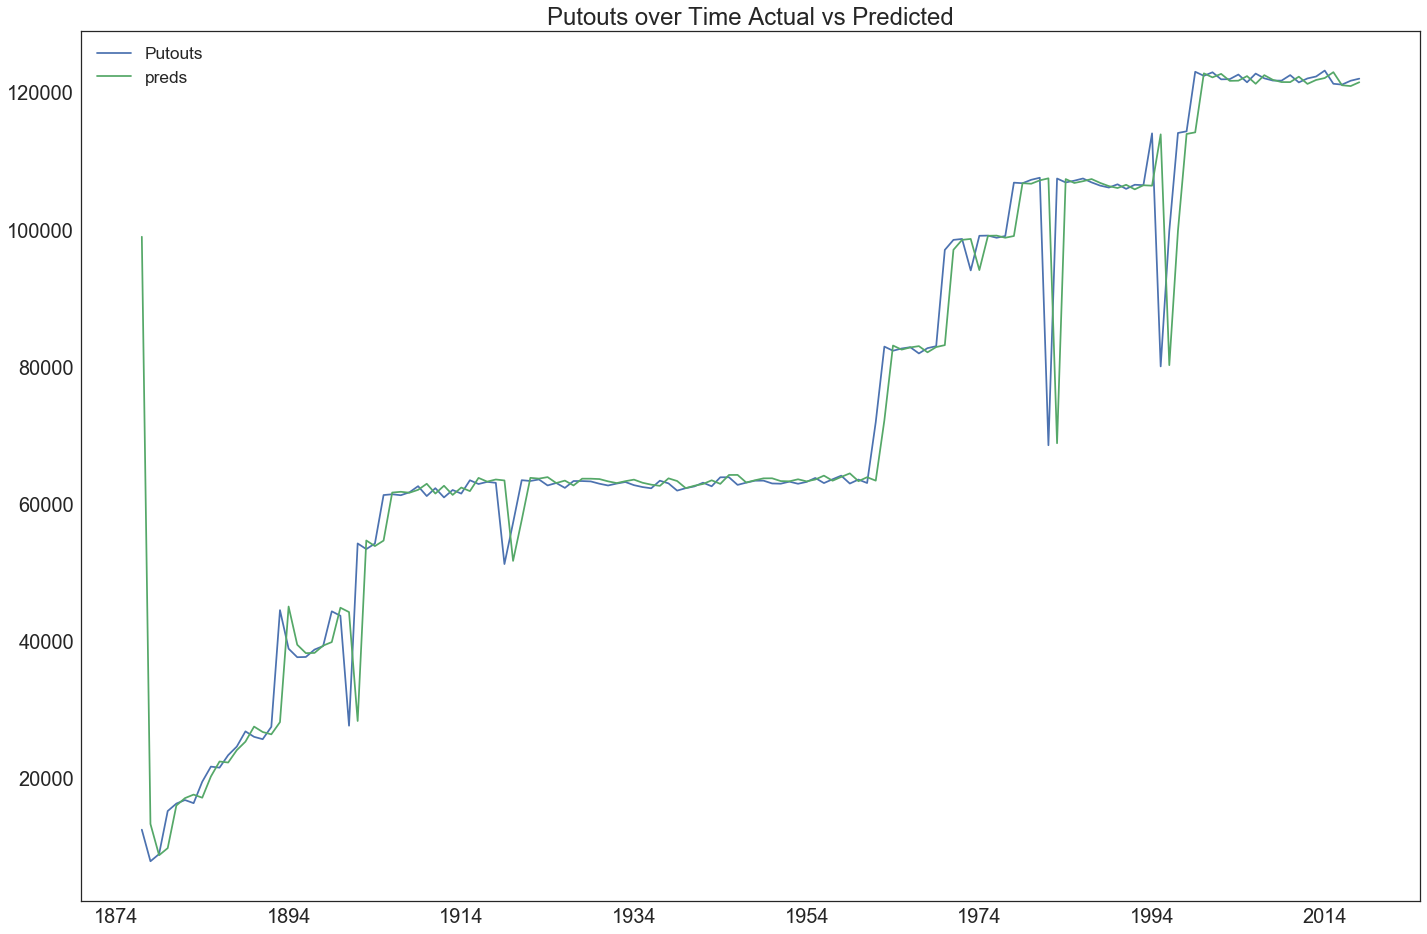

In [267]:
plt.figure(figsize=(24,16))
plt.plot(fielding_year['po'], label='Putouts')
plt.plot(preds, label='preds')
plt.title('Putouts over Time Actual vs Predicted', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize='xx-large');

## forecasting

In [268]:
forecast_f_po = model.forecast(steps=1, # number of out of sample forecast
               exog=None, # only applies if armax
               alpha=0.05 # confidence intervals of the forecast
              )

# returns forecast, std err, and confidence interval range

In [269]:
forecast_f_po

(array([121832.29018855]),
 array([7106.82280073]),
 array([[107903.17345462, 135761.40692248]]))

In [270]:
forecast_f_po[0]

array([121832.29018855])

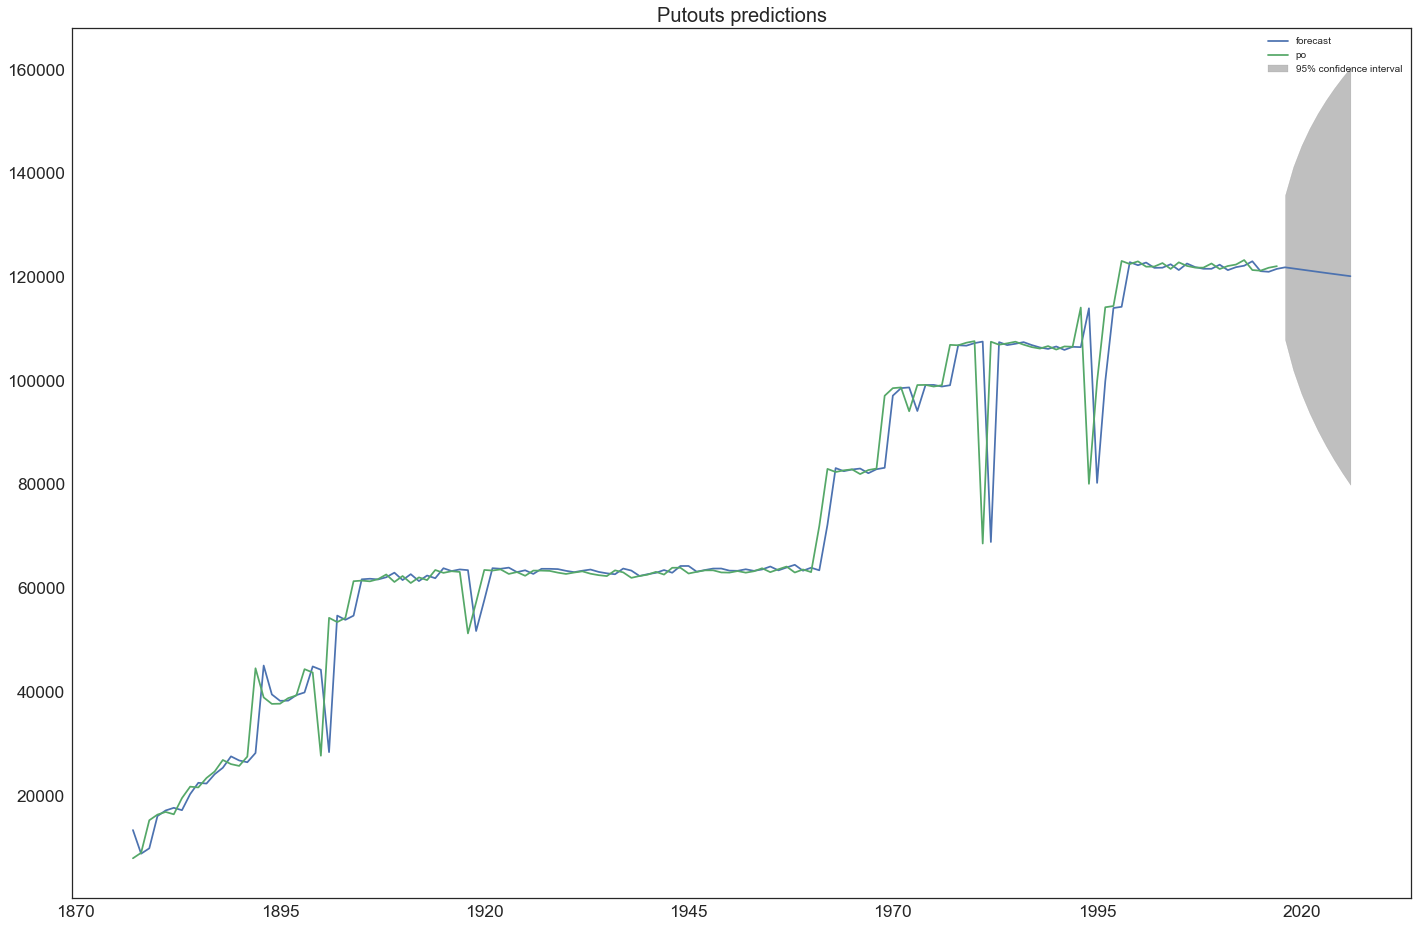

In [271]:
fig, ax = plt.subplots(figsize = (24, 16))
ax.set_title('Putouts predictions', fontsize=20)
ax.tick_params(labelsize='xx-large')
model.plot_predict(start=1, end=150, alpha=0.05, ax = ax)

plt.show();

### Double Plays

In [301]:
ar_f_dp = ARMA(endog = fielding_year['dp'], # y variable
          order= (2,0))  # (p,q) <--- talk about q later

In [302]:
model = ar_f_dp.fit()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

In [303]:
preds = model.predict() #generated prediction values. Since autoregression, don't have to pass anything into model

In [304]:
r2_score(preds, fielding_year['dp'])

0.9356018465498184

In [305]:
fielding_year['predicted'] = preds
fielding_year[['dp', 'predicted']].head(10)

,dp,predicted
1876-12-31,537,6036.051255
1877-12-31,410,606.643700
1878-12-31,509,498.772344
1879-12-31,781,525.886175
1880-12-31,923,741.154227
1881-12-31,1168,922.776930
1882-12-31,1038,1133.278793
1883-12-31,1190,1122.261325
1884-12-31,1190,1184.315415
1885-12-31,1284,1232.085388


In [306]:
fielding_year[['dp', 'predicted']].tail(10)

,dp,predicted
2008-12-31,11471,11676.591150
2009-12-31,11389,11516.197533
2010-12-31,10937,11368.283119
2011-12-31,10447,11036.490670
2012-12-31,10600,10562.688554
2013-12-31,10938,10512.280274
2014-12-31,10297,10789.203838
2015-12-31,10850,10461.446921
2016-12-31,10806,10634.398702
2017-12-31,11052,10778.403672


In [307]:
np.mean(fielding_year['predicted'])

6412.306303845212

In [308]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                     dp   No. Observations:                  142
Model:                     ARMA(2, 0)   Log Likelihood               -1125.962
Method:                       css-mle   S.D. of innovations            662.935
Date:                Thu, 18 Oct 2018   AIC                           2259.925
Time:                        10:10:43   BIC                           2271.748
Sample:                    12-31-1876   HQIC                          2264.729
                         - 12-31-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6036.0513   3629.702      1.663      0.099   -1078.033    1.32e+04
ar.L1.dp       0.6770      0.079      8.537      0.000       0.522       0.832
ar.L2.dp       0.3143      0.080      3.938      0.0

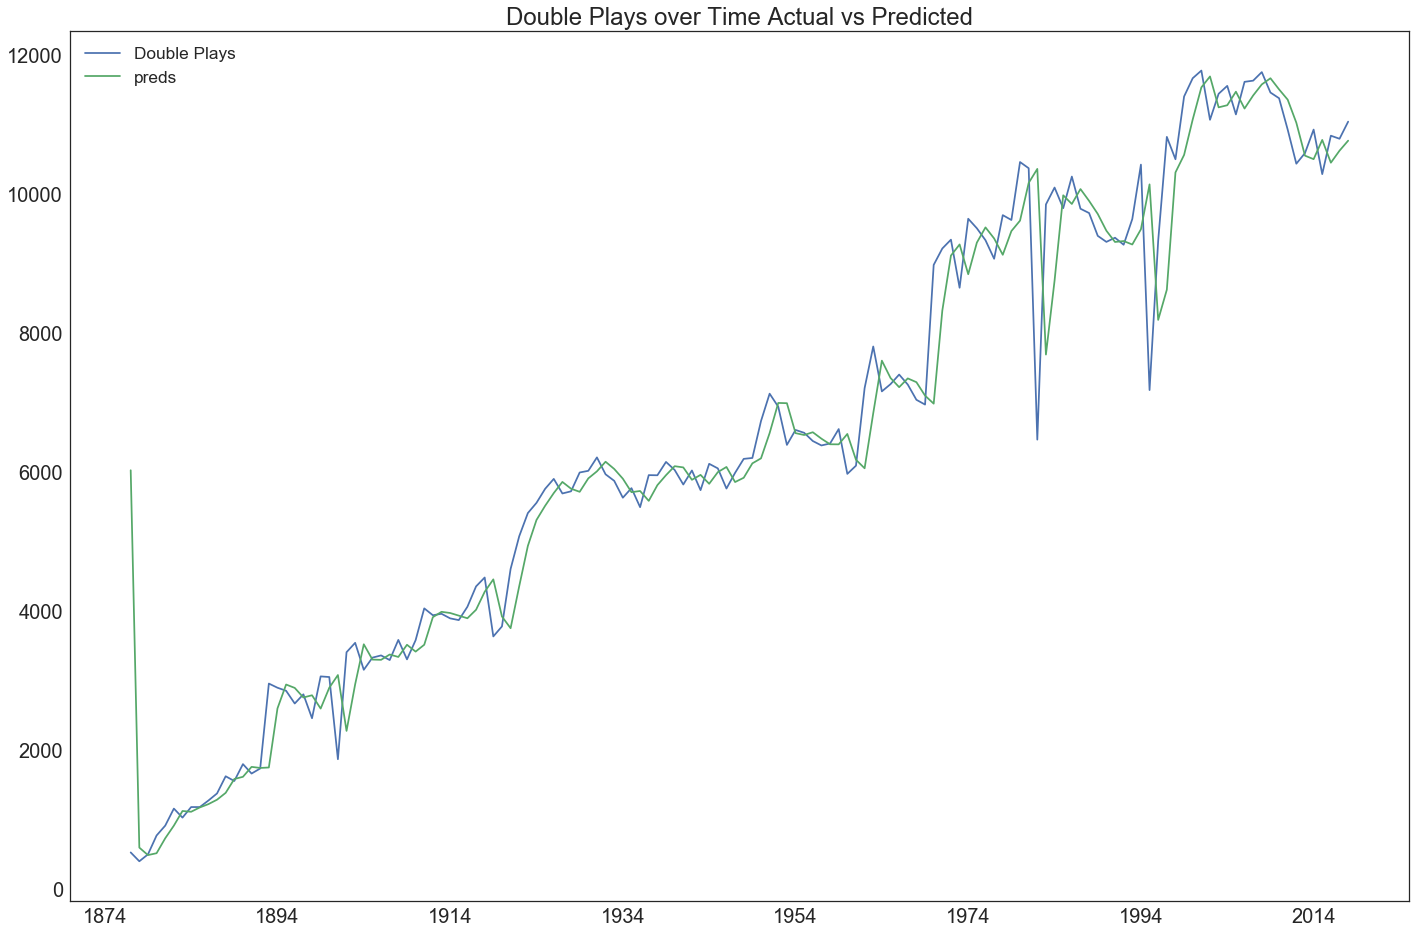

In [309]:
plt.figure(figsize=(24,16))
plt.plot(fielding_year['dp'], label='Double Plays')
plt.plot(preds, label='preds')
plt.title('Double Plays over Time Actual vs Predicted', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize='xx-large');

## forecasting

In [310]:
forecast_f_dp = model.forecast(steps=1, # number of out of sample forecast
               exog=None, # only applies if armax
               alpha=0.05 # confidence intervals of the forecast
              )

# returns forecast, std err, and confidence interval range

In [311]:
forecast_f_dp

(array([10931.12721268]),
 array([662.93485938]),
 array([[ 9631.7987642 , 12230.45566116]]))

In [312]:
forecast_f_dp[0]

array([10931.12721268])

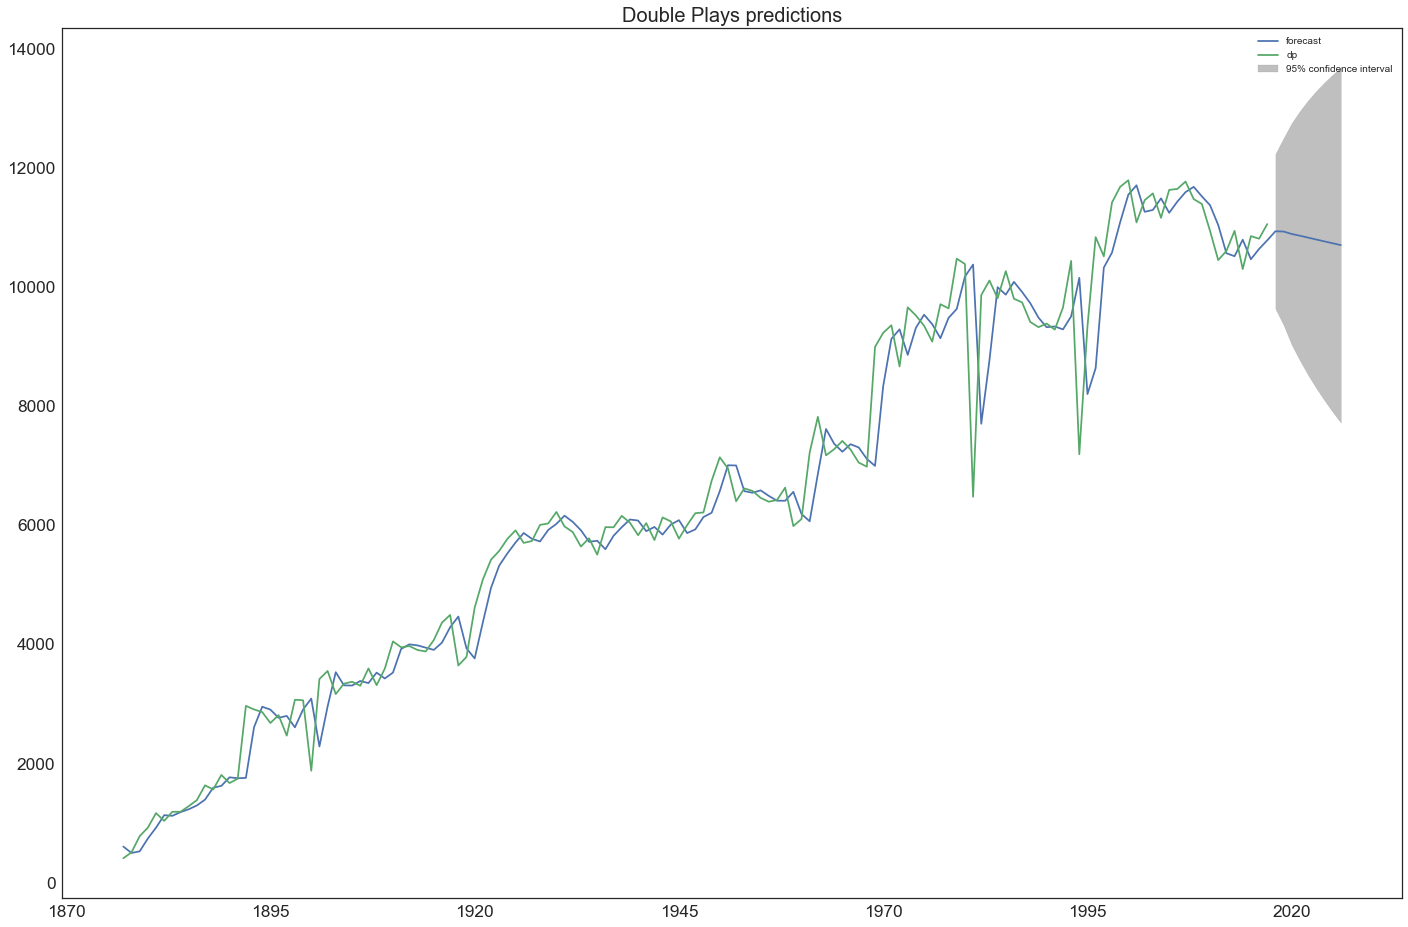

In [313]:
fig, ax = plt.subplots(figsize = (24, 16))
ax.set_title('Double Plays predictions', fontsize=20)
ax.tick_params(labelsize='xx-large')
model.plot_predict(start=1, end=150, alpha=0.05, ax = ax)

plt.show();